# Определение наиболее выгодного региона для нефтедобычи

Нам предоставлены пробы нефти в трёх регионах. В каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль; проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Признаки:**

- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек;
- `product` — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [ ]:
# загружаем необходимые библиотеки и модули

!pip install sweetviz

import pandas as pd
import sweetviz as sv
import numpy as np
import matplotlib.pyplot as plt


from scipy import stats as st
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


     |████████████████████████████████| 15.1 MB 1.0 MB/s eta 0:00:01


In [ ]:
# сохраним данные о регионах в трех датасетах
region_1 = pd.read_csv('/datasets/geo_data_0.csv')
region_2 = pd.read_csv('/datasets/geo_data_1.csv')
region_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [ ]:
# создадим 3 отчета о данных, используя библиотеку Sweet-Viz
report_1 = sv.analyze([region_1, 'Регион № 1'])
report_2 = sv.analyze([region_2, 'Регион № 2'])
report_3 = sv.analyze([region_3, 'Регион № 3'])

                                             |          | [  0%]   00:00 -> (? left)

                                             |          | [  0%]   00:00 -> (? left)

                                             |          | [  0%]   00:00 -> (? left)


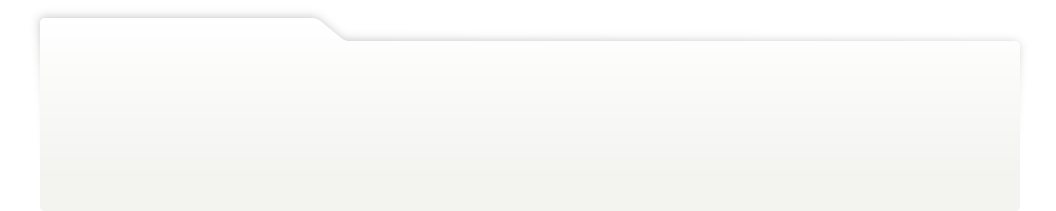
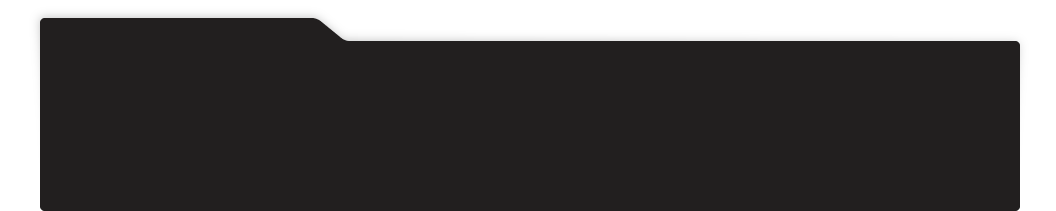
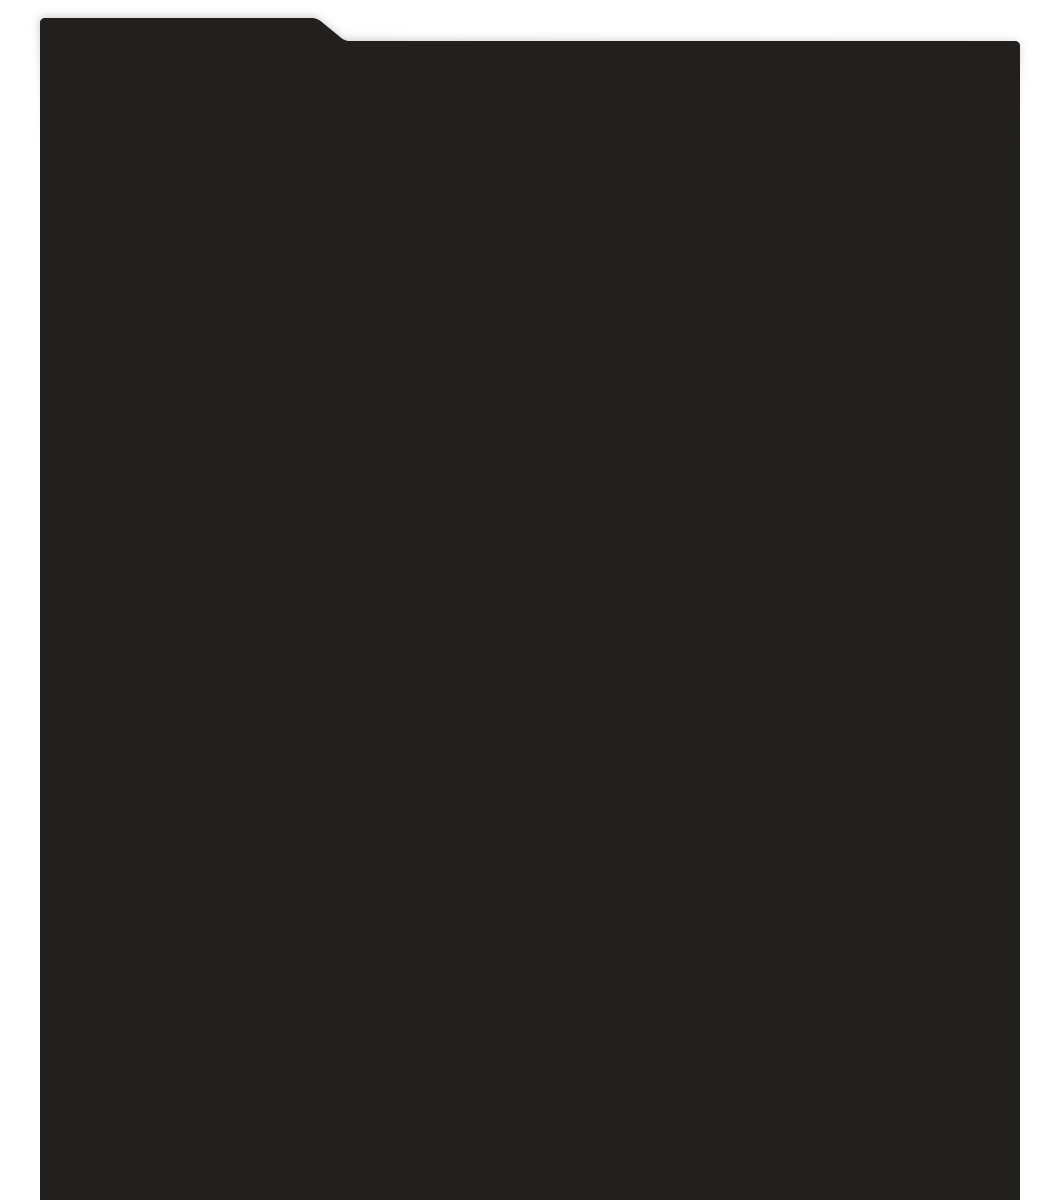
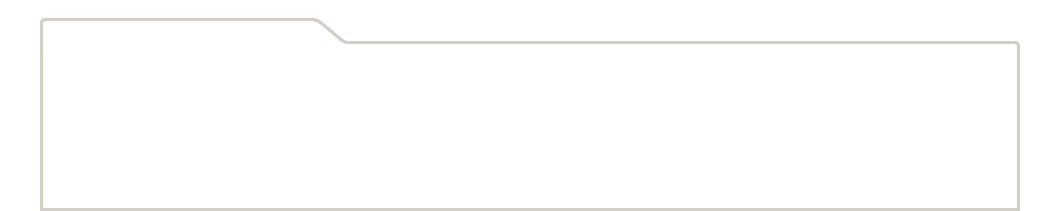
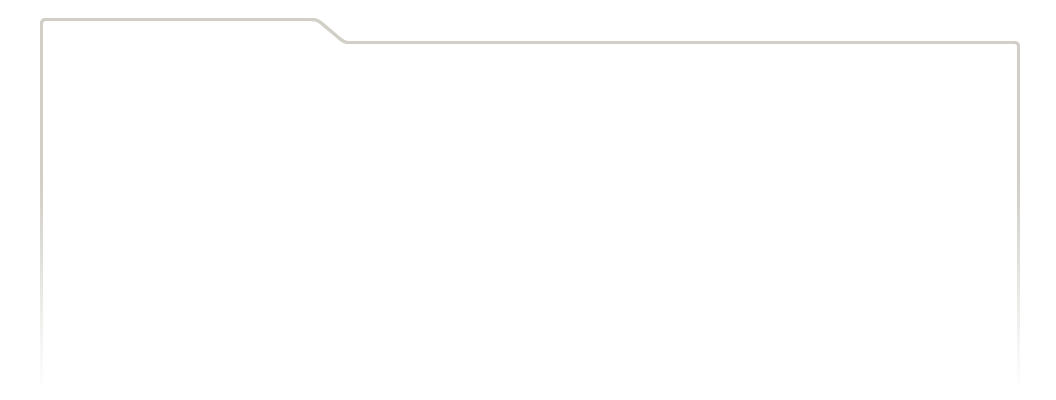
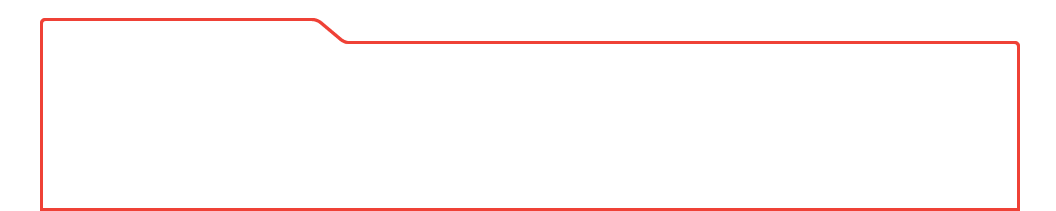
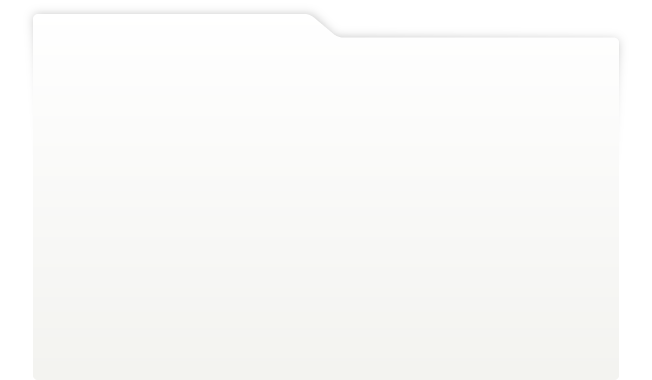
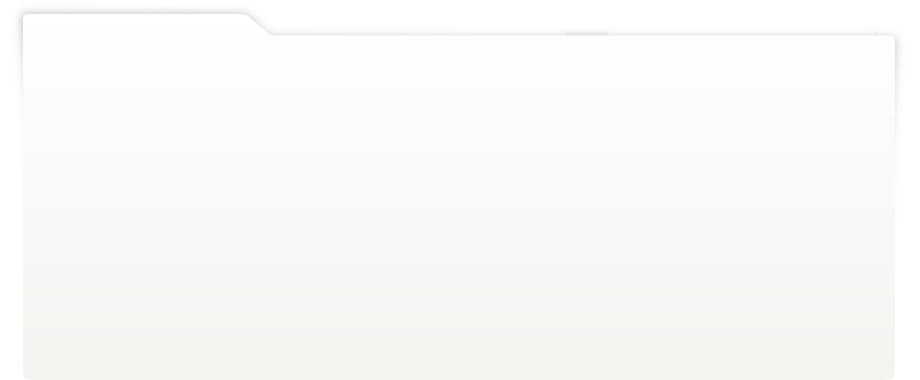
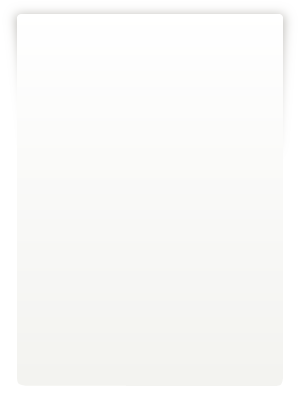
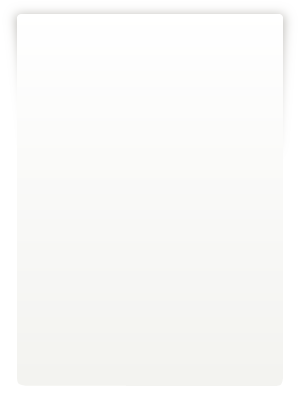
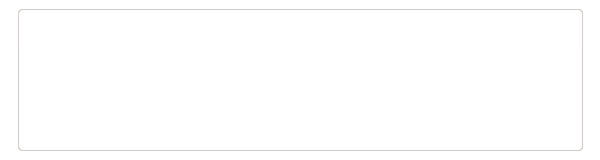
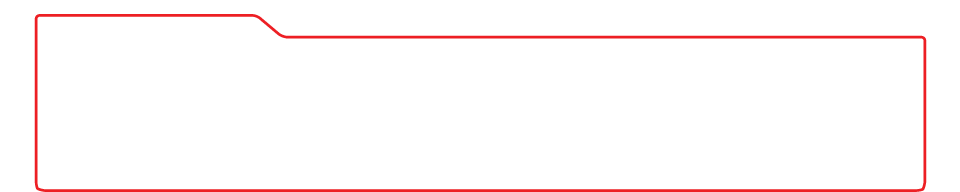
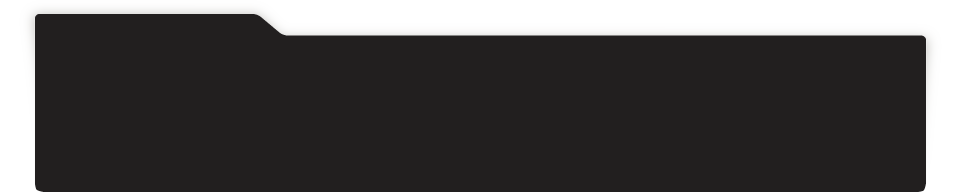
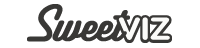
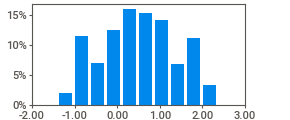
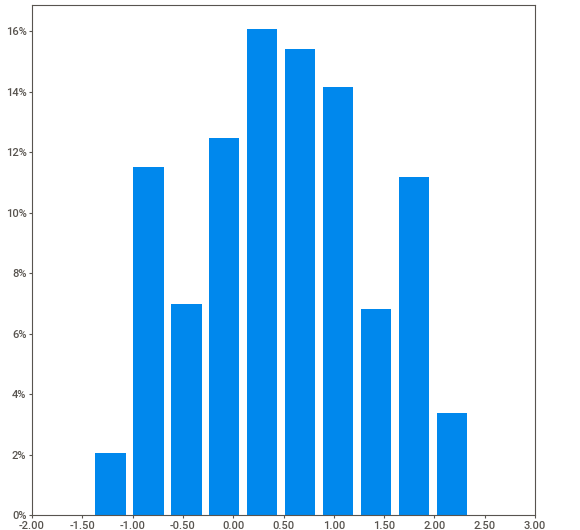
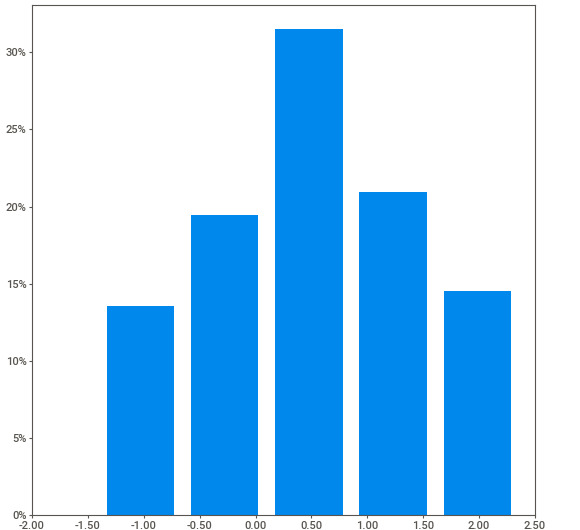
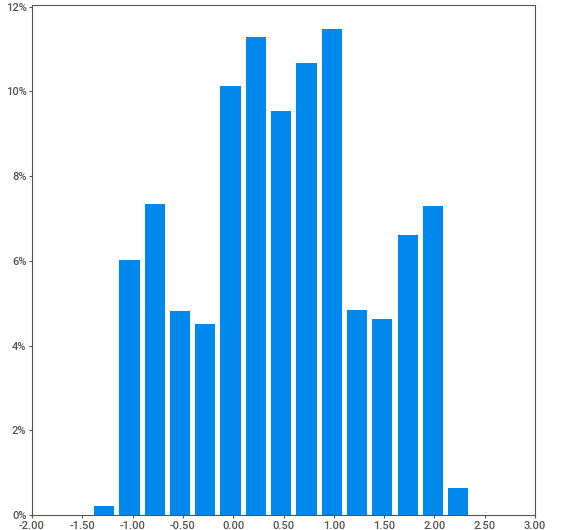
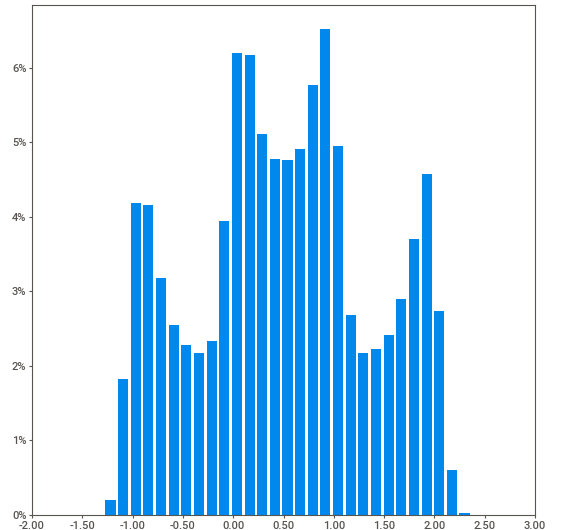
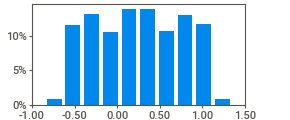
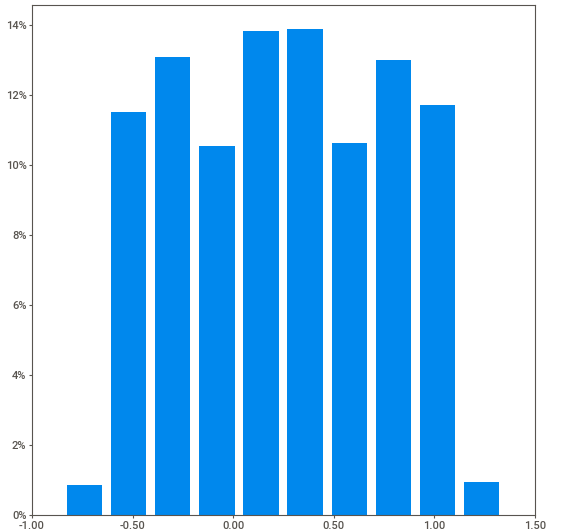
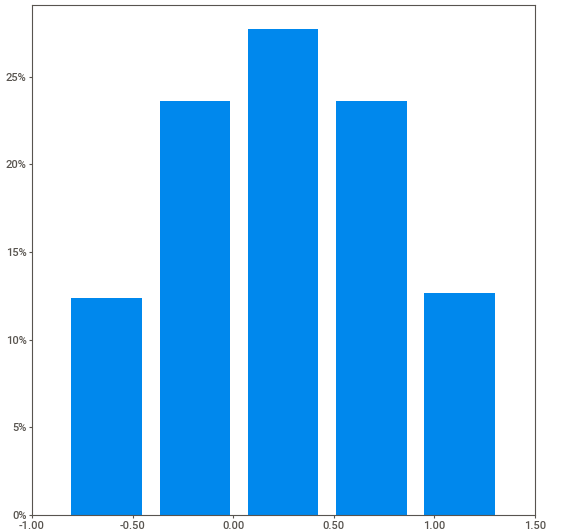
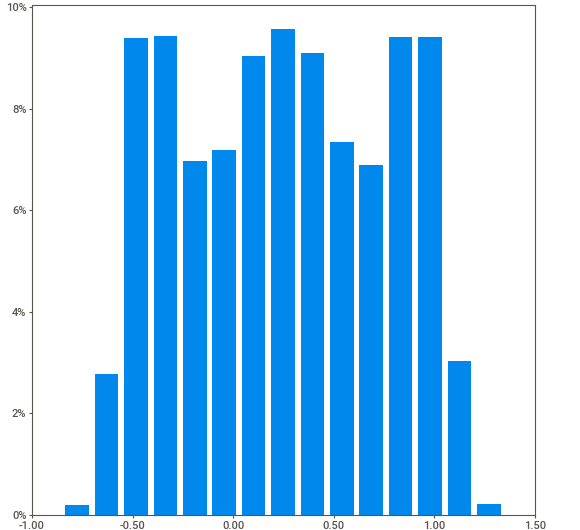
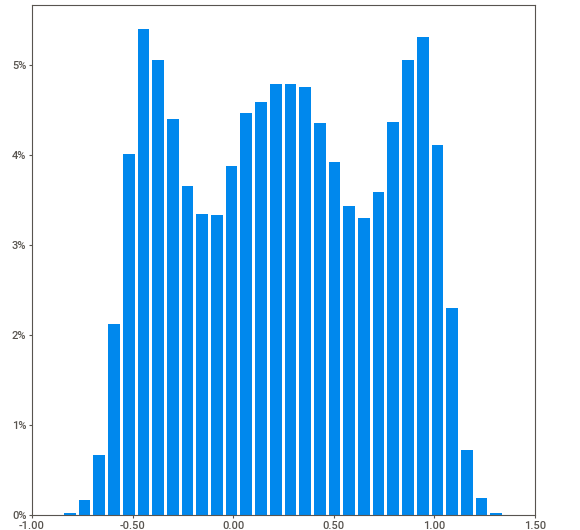
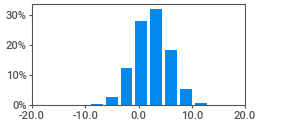
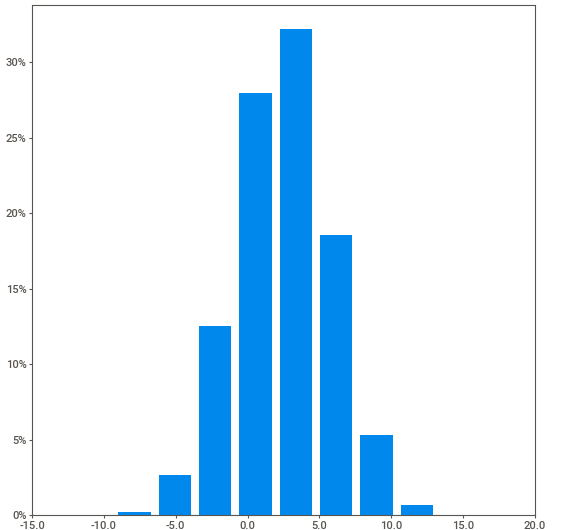
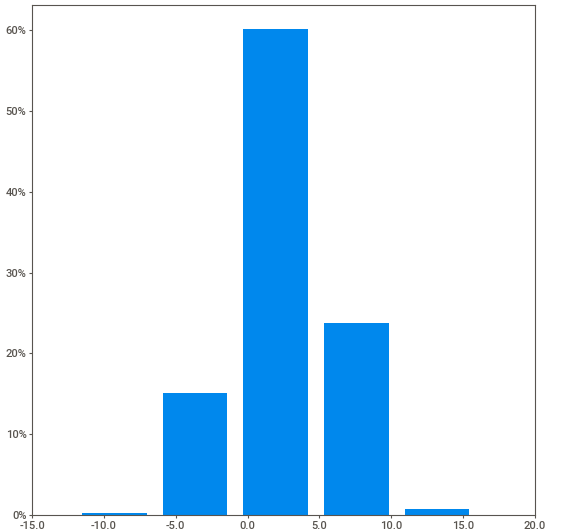
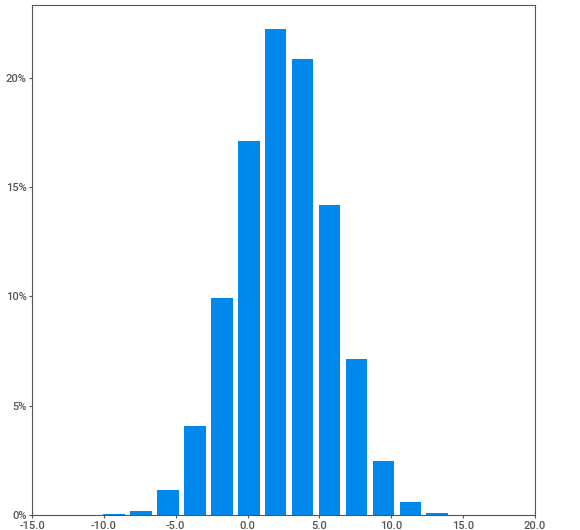
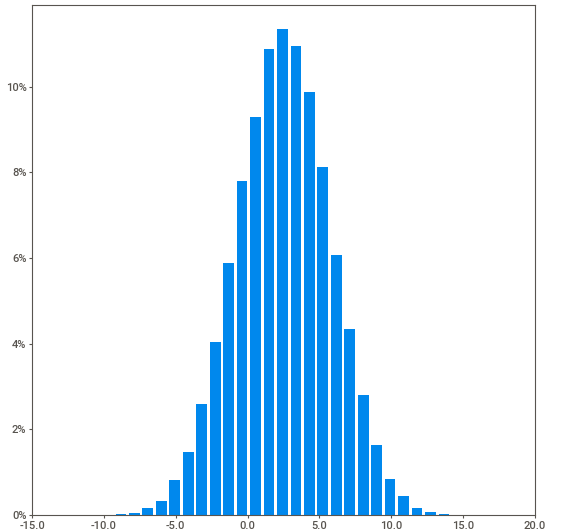
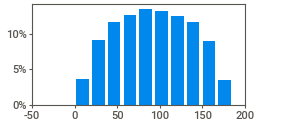
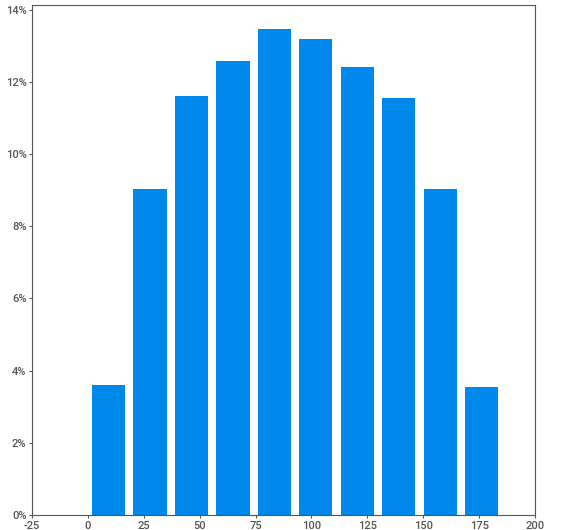
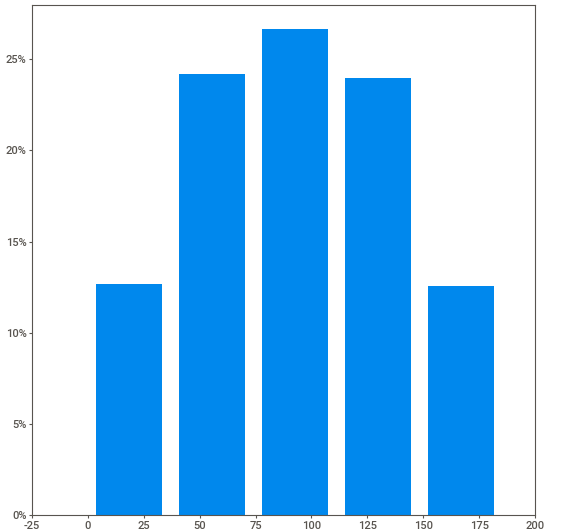
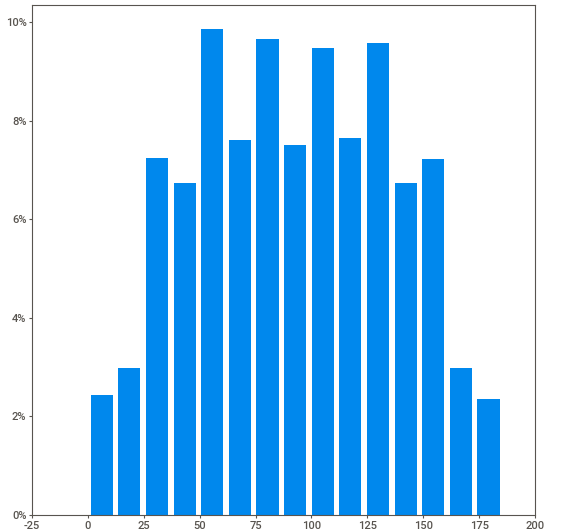
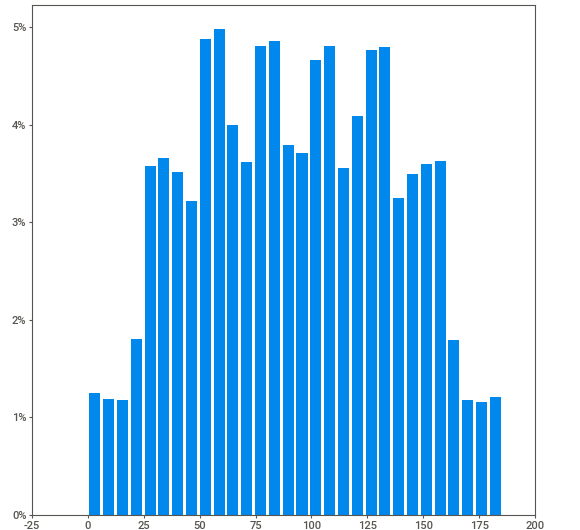
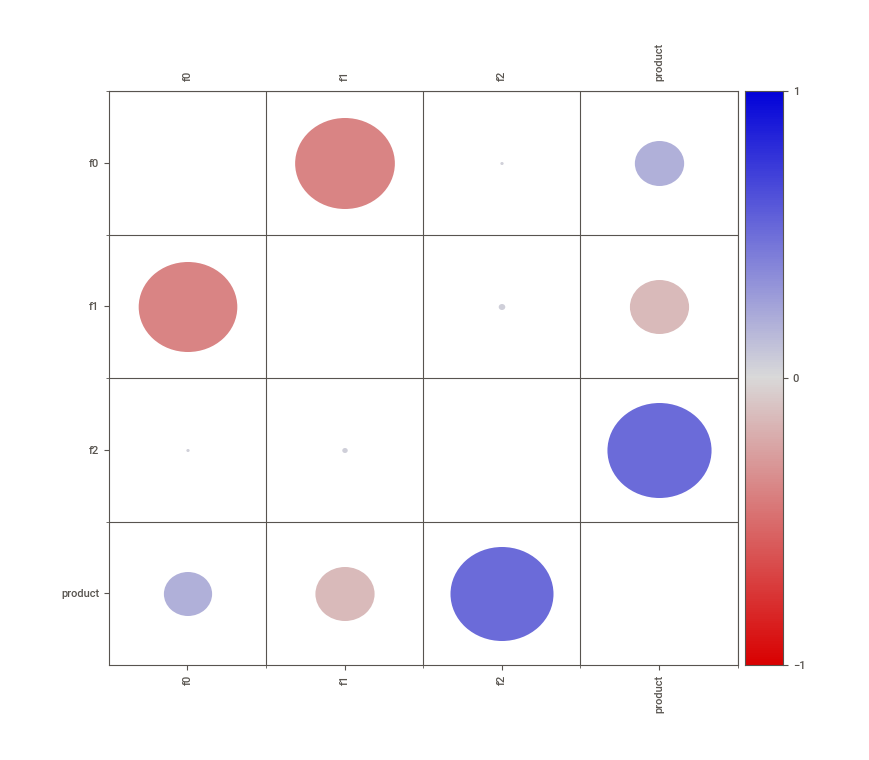
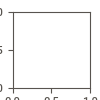

In [ ]:
# отчет о регионе № 1
report_1.show_notebook()

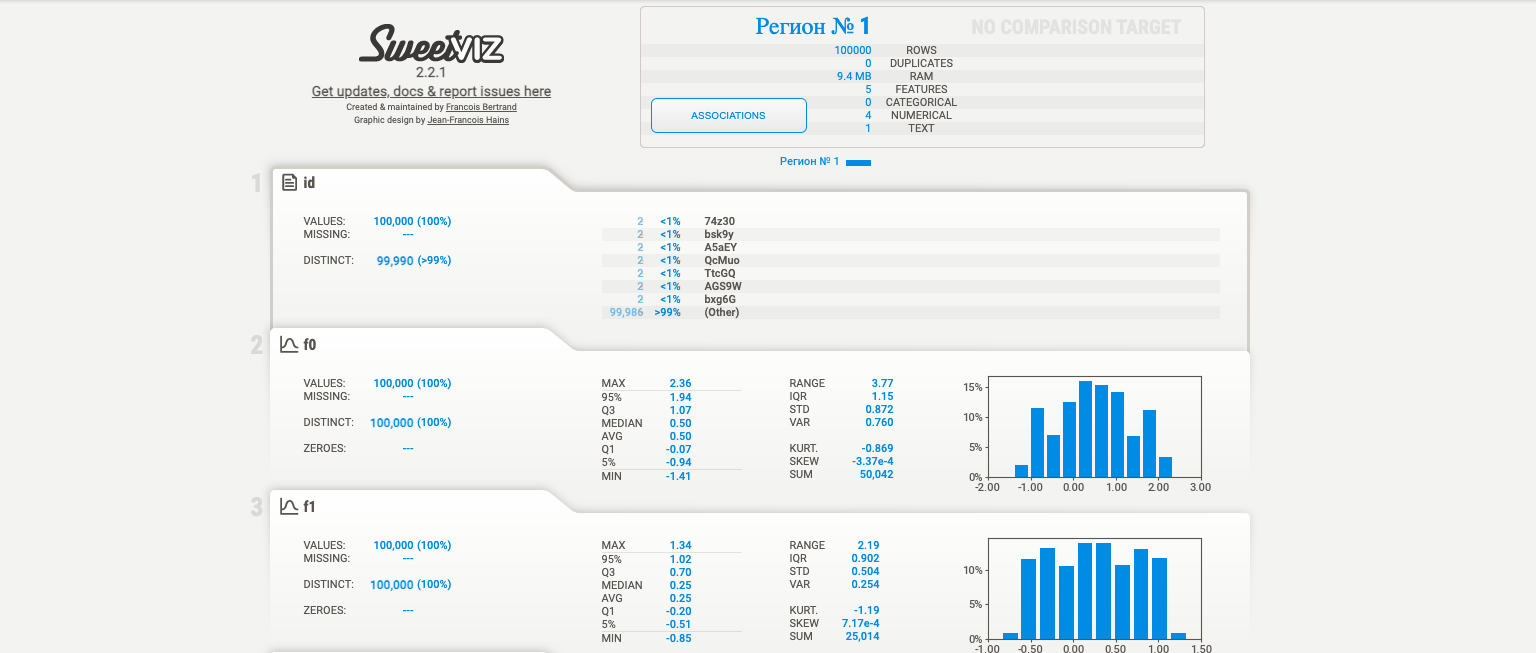

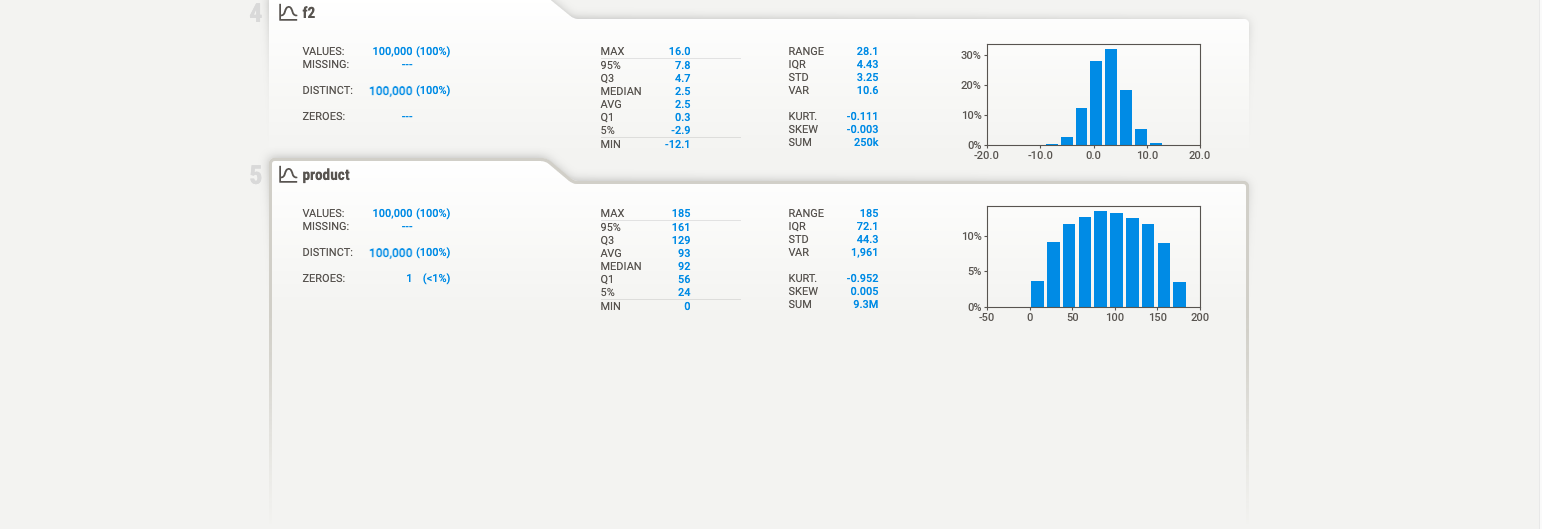

**Вывод:**

- Пропуски и явные дубликаты в датасете отсутствуют.
- Распределение признаков f0, f2 и product нормальное, а f1 - равномерное.
- Есть подозрения на мультиколлинеарность признаков f1 и f0.
- Наибольшая корреляция с целевым признаком наблюдается у f2.

In [ ]:
# выведем коэффициент корреляции Пирсона для f1 и f0
region_1['f0'].corr(region_1['f1'])

-0.4407228509719545

На практике пороговое значение коэффициента зависит от задачи и находится в диапазоне от 0.6 до 1.0. В нашем случае можно сделать вывод, что мультиколлинеарности признаков нет.


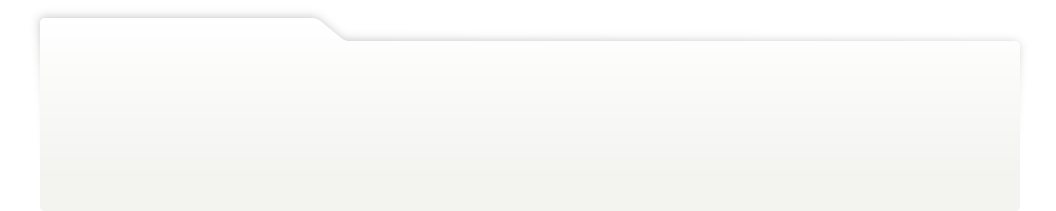
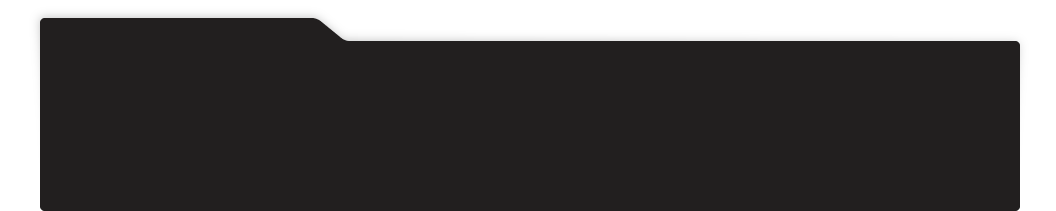
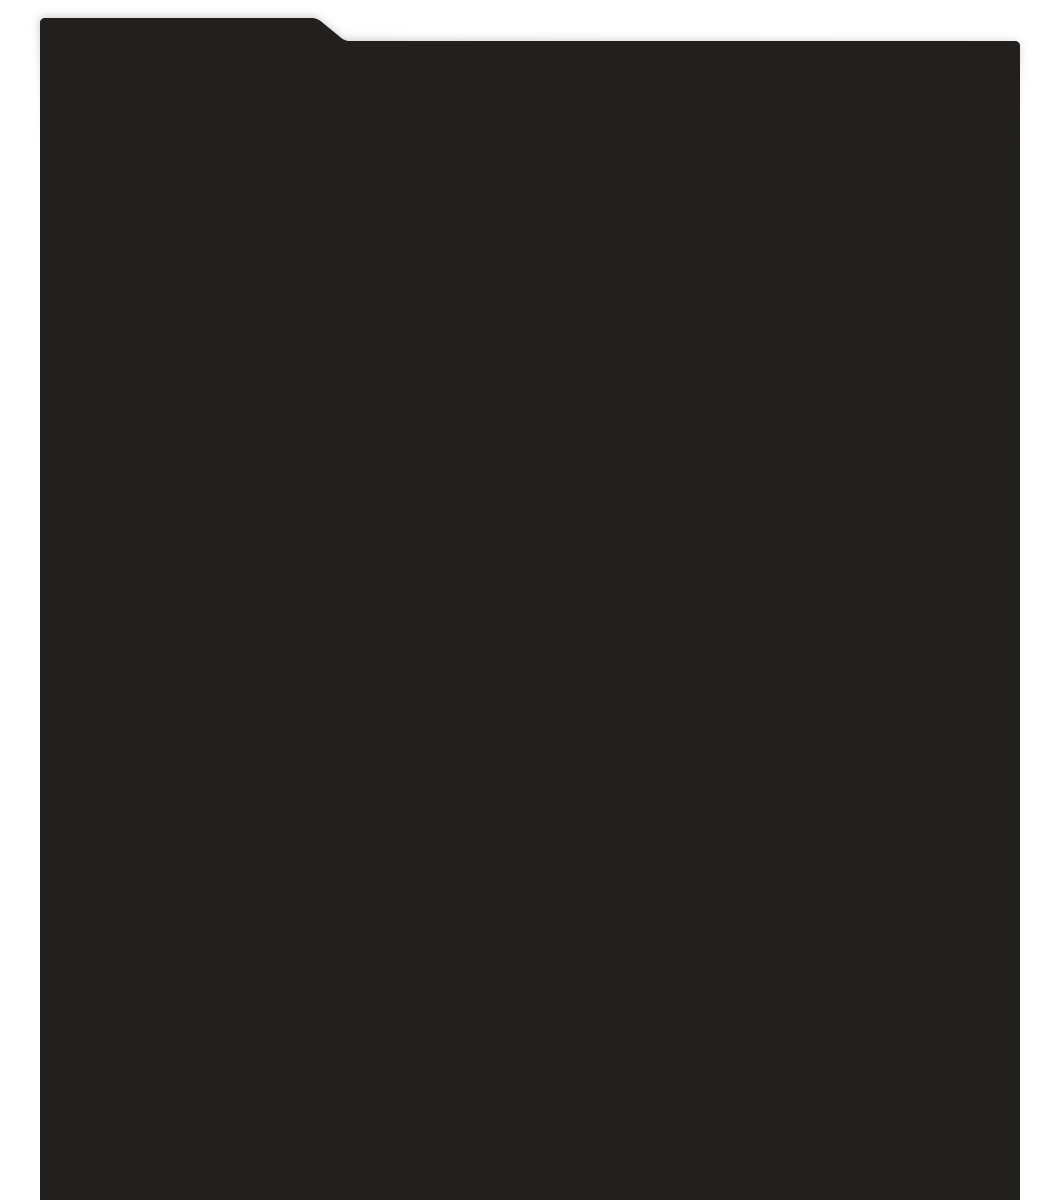
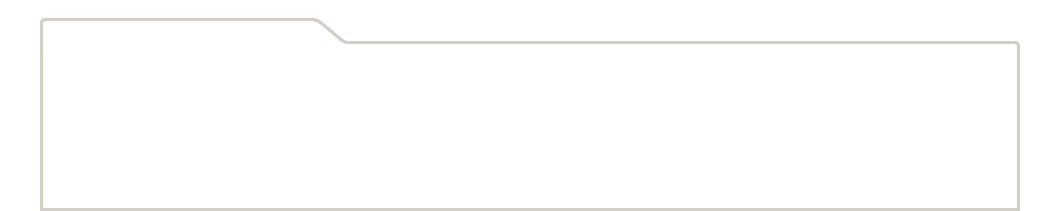
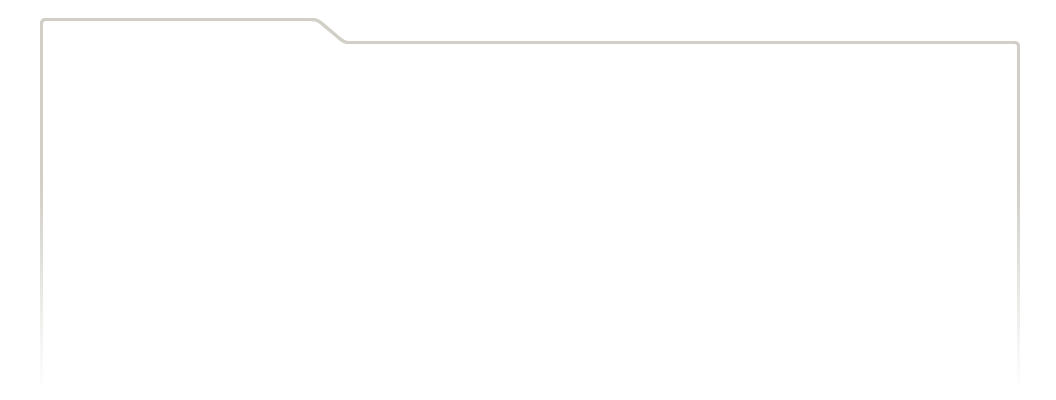
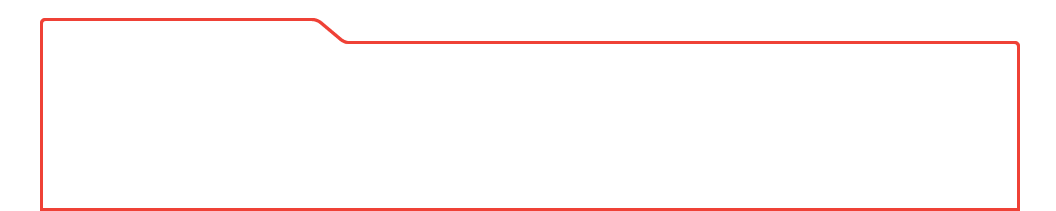
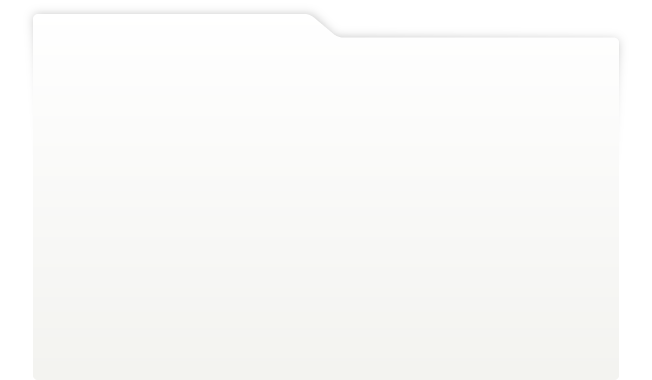
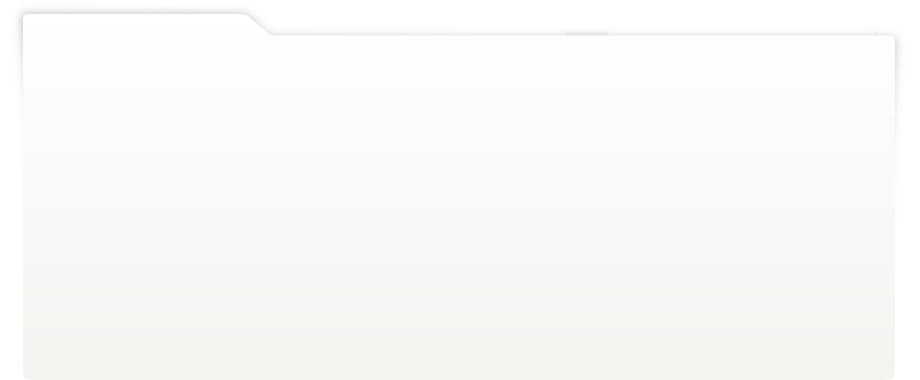
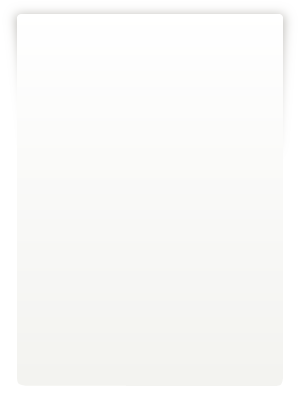
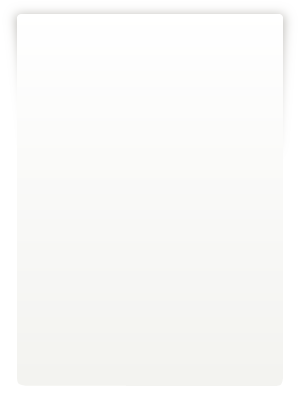
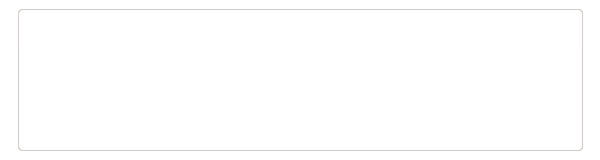
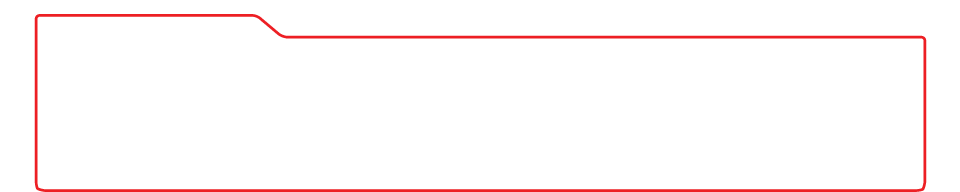
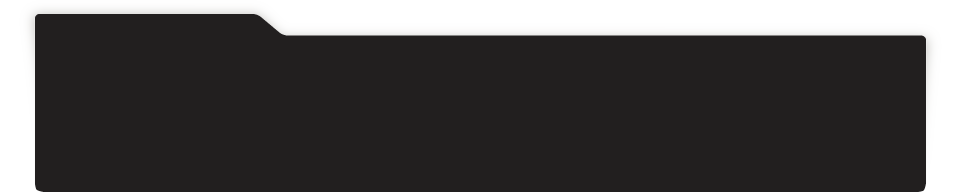
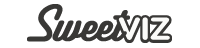
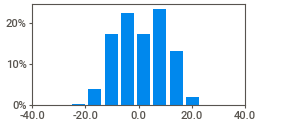
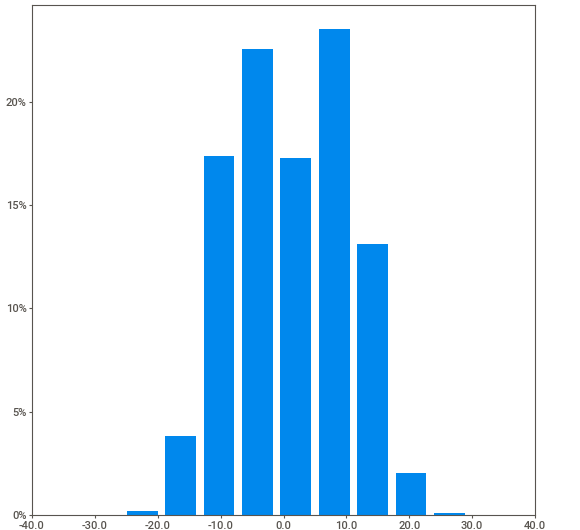
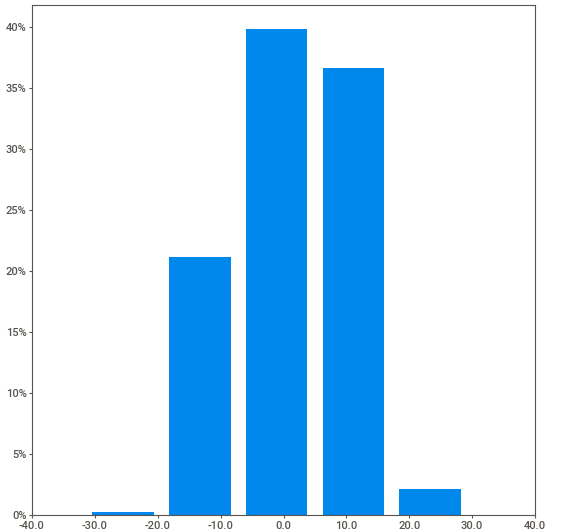
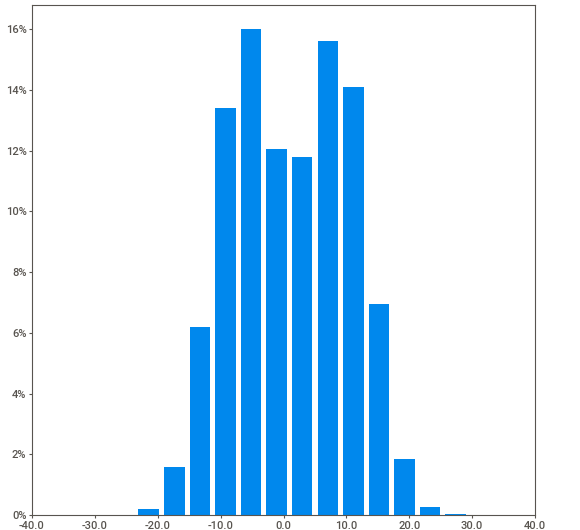
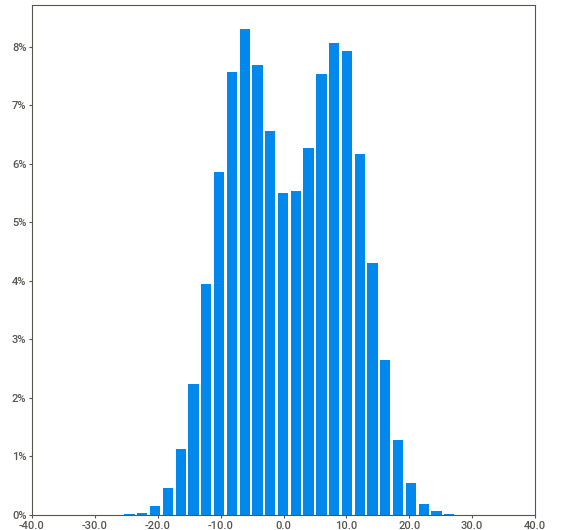
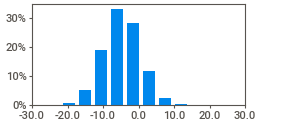
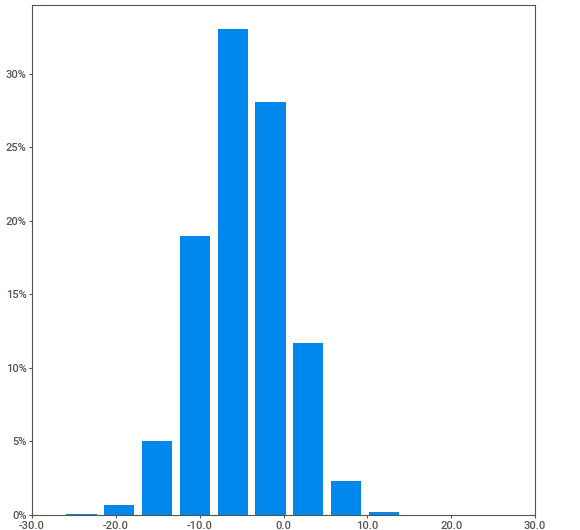
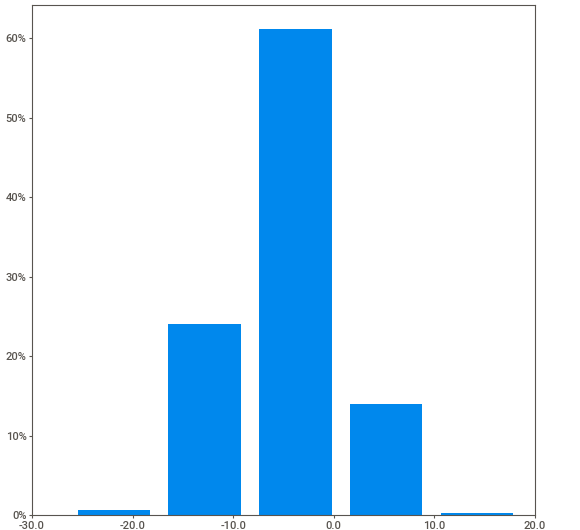
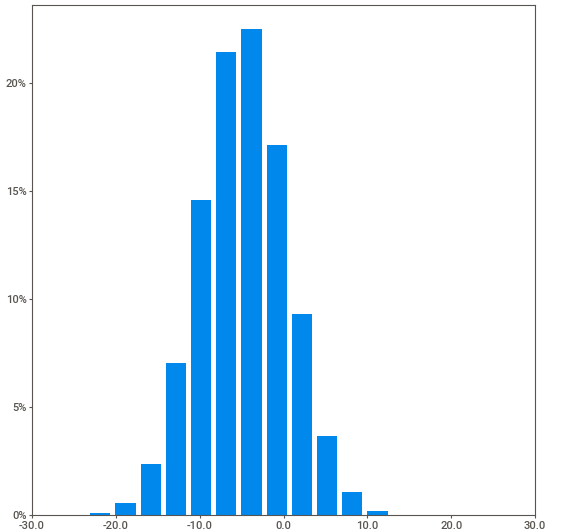
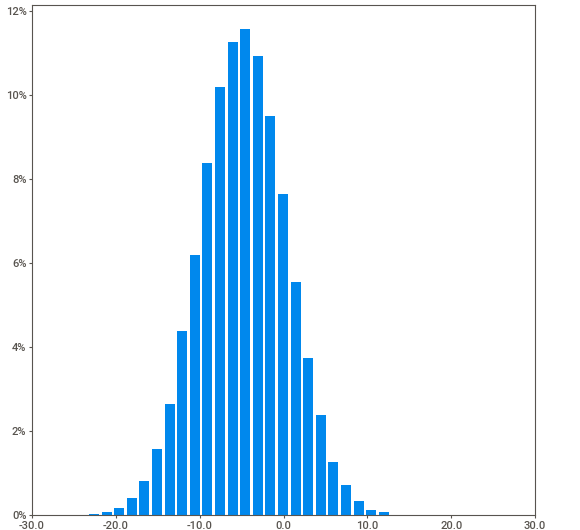
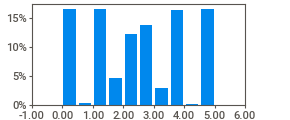
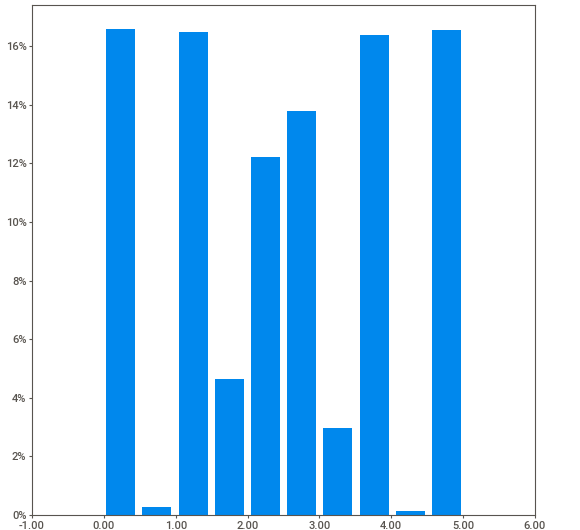
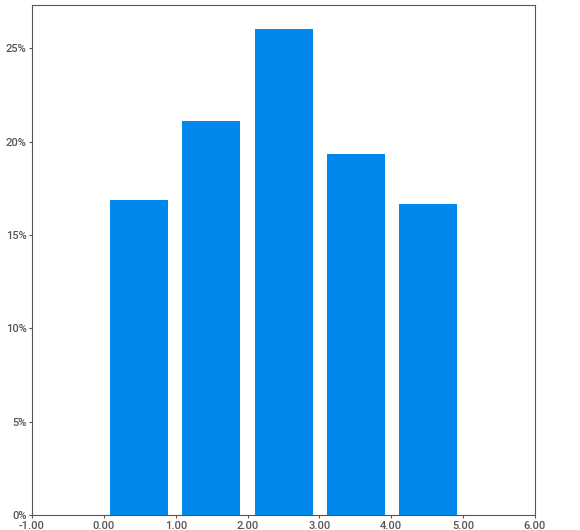
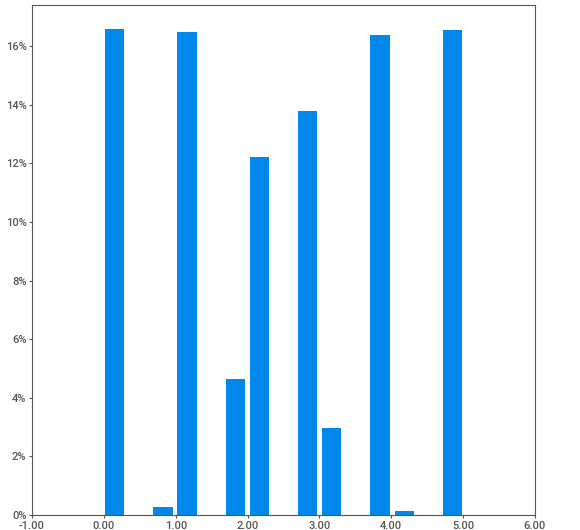
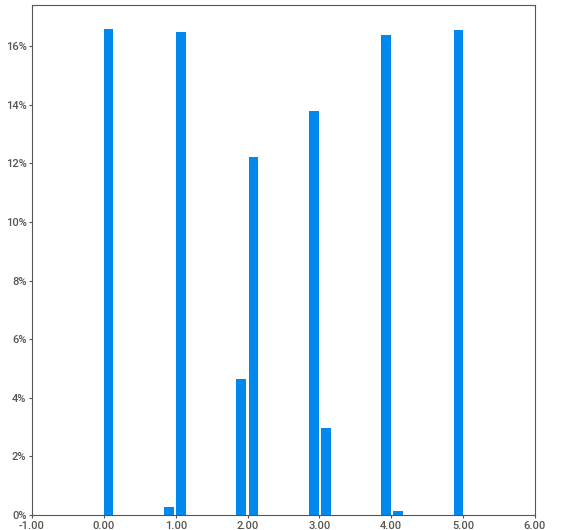
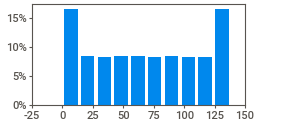
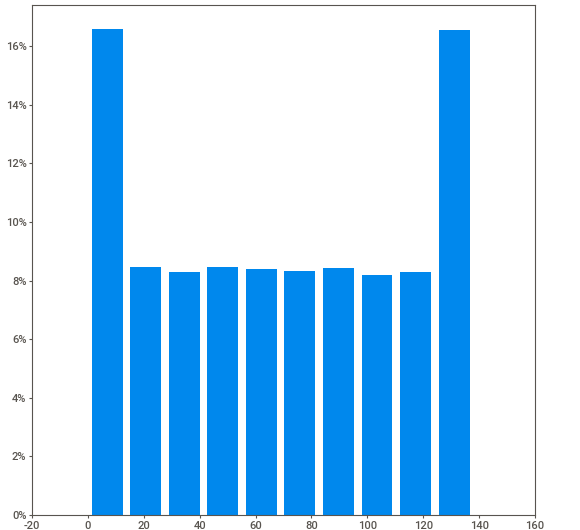
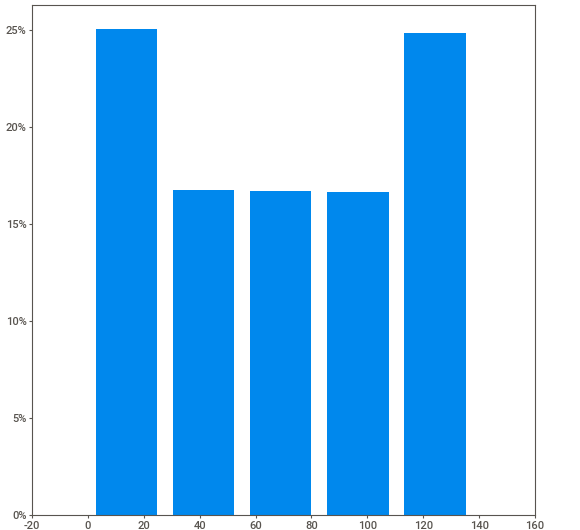
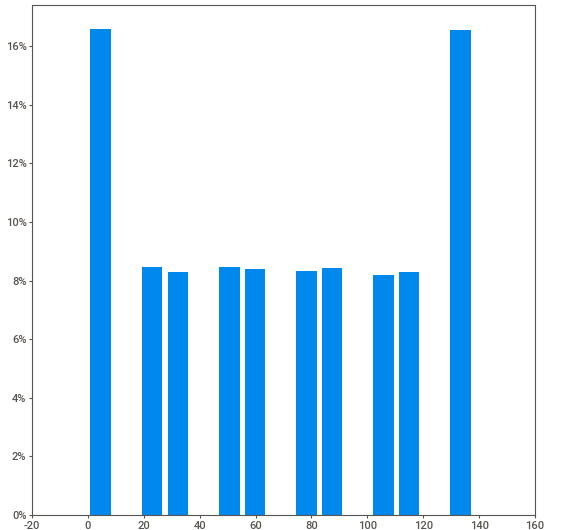
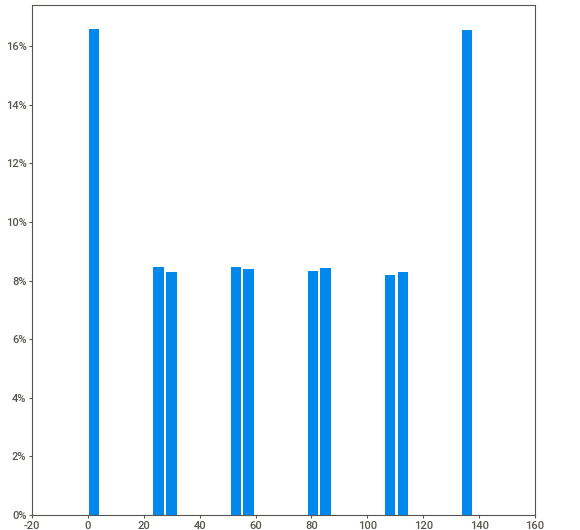
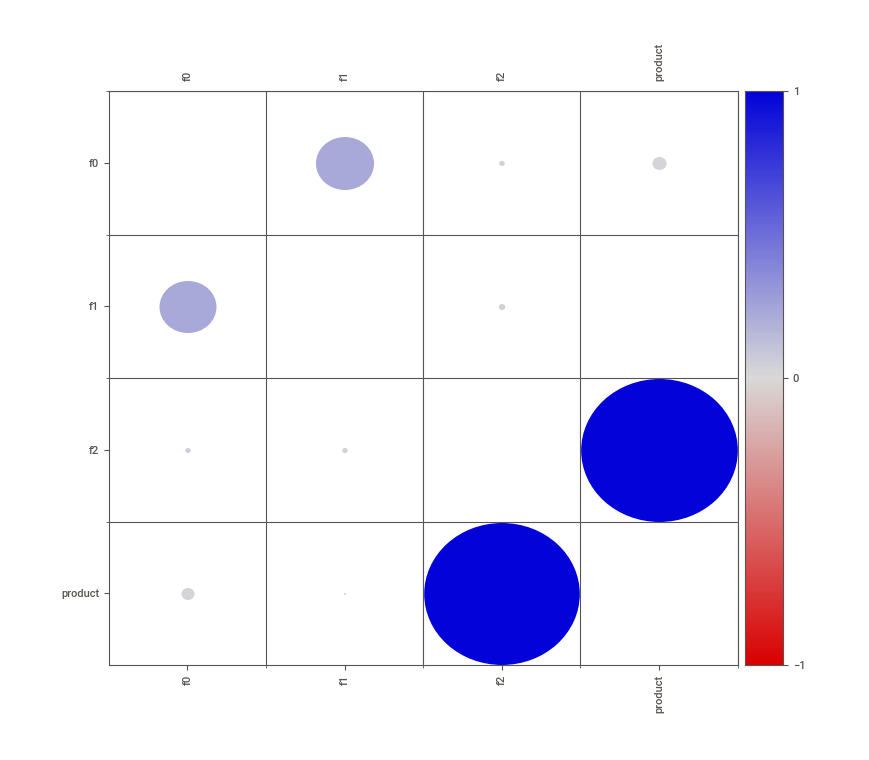
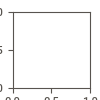

In [ ]:
# отчет о регионе № 2
report_2.show_notebook()

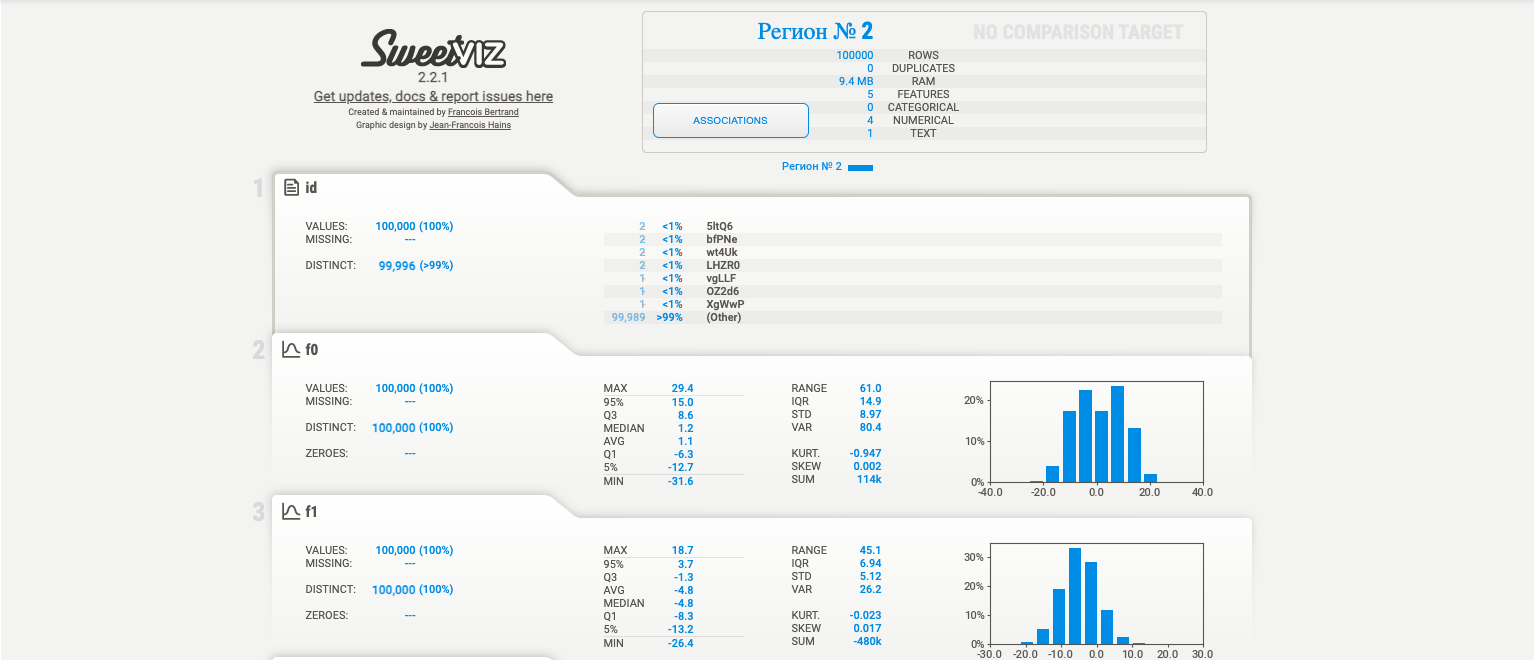

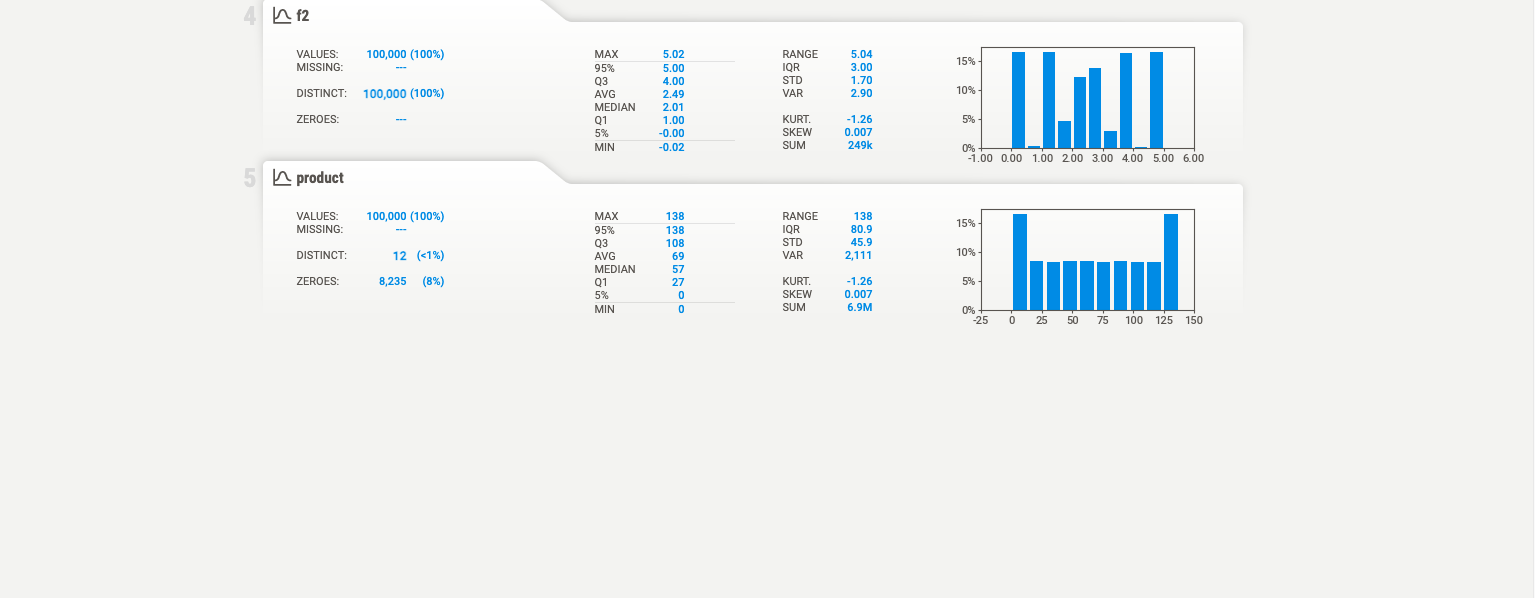

**Вывод:**

- Пропуски и явные дубликаты в датасете отсутствуют.
- Распределение признаков f0 и f1 нормальное.
- Признаки f2 и product распределены подозрительно. Имеется много одинаковых значений. Возможно, это связано с тем, что данные образованы синтетическим путем. Качество прогнозов модели, обученной на этих данных, скорее всего будет высоким, но для реальных задач она будет непригодна.
- Наибольшая корреляция наблюдается между целевым признаком и f2.

In [ ]:
# выведем коэффициент корреляции Пирсона для f1 и product
region_2['product'].corr(region_2['f2'])

0.9993969704906553

Коэффициент почти равен единице, к реальности это имеет мало отношения.


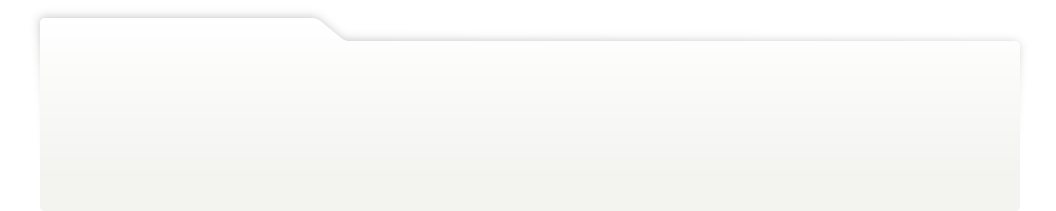
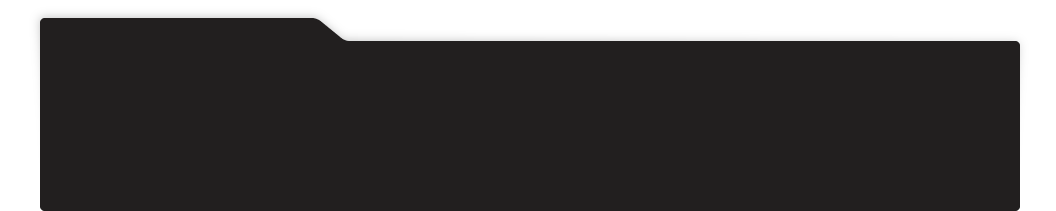
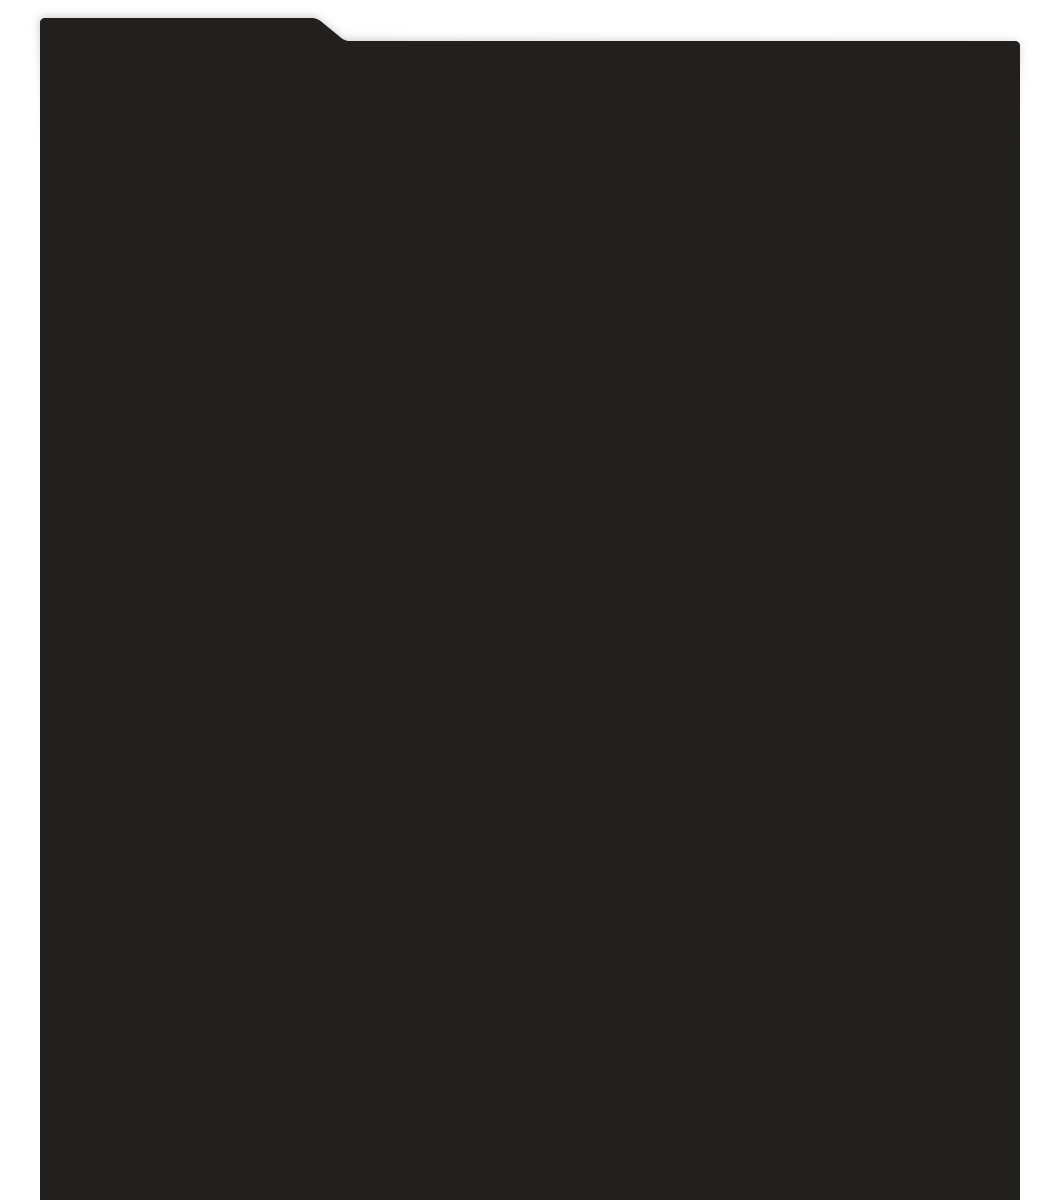
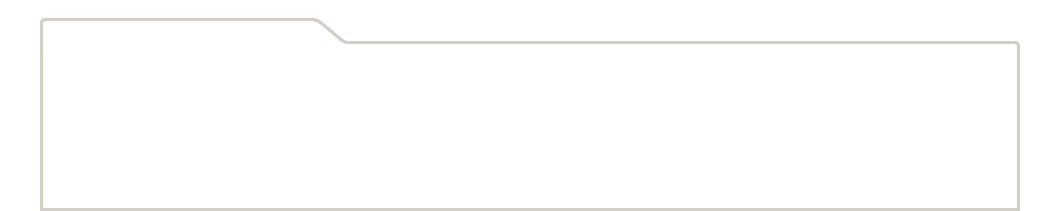
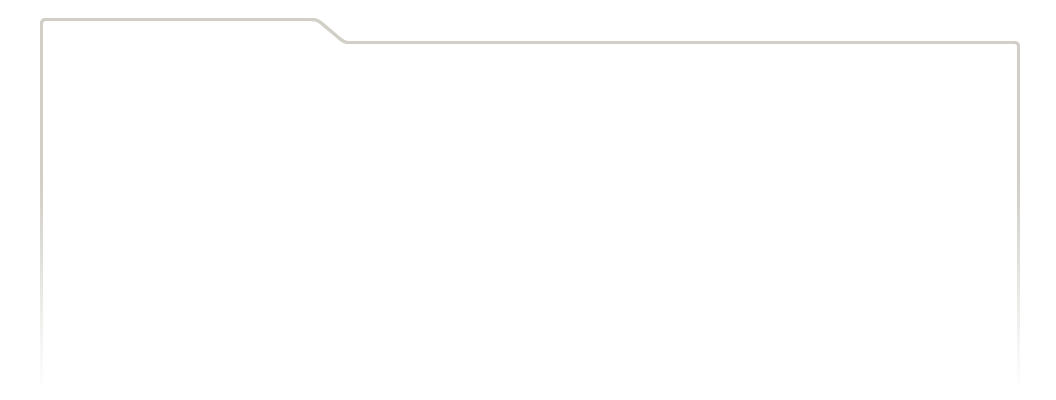
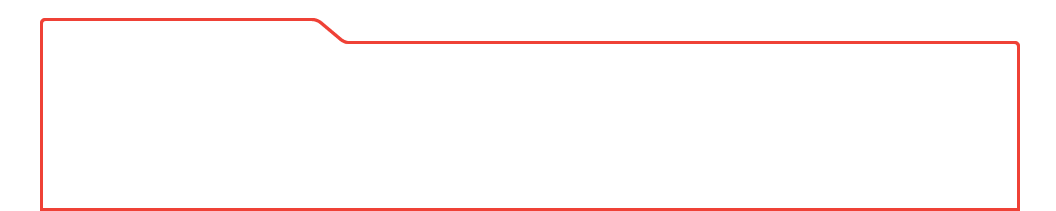
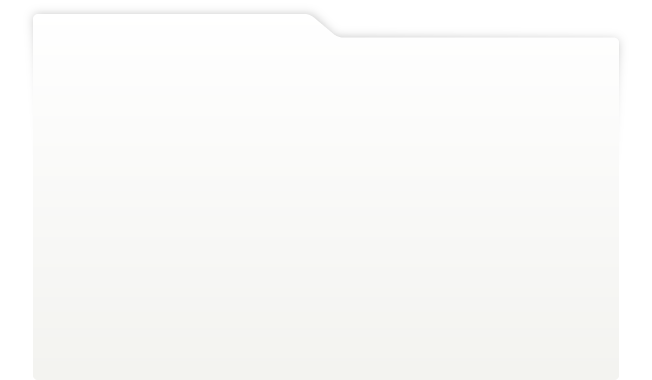
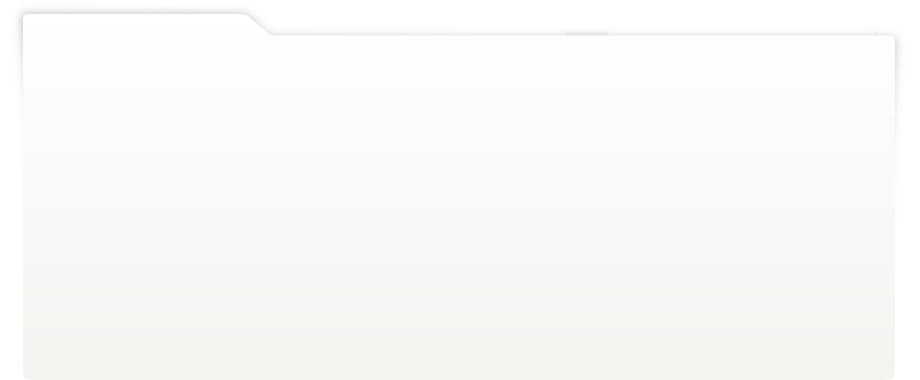
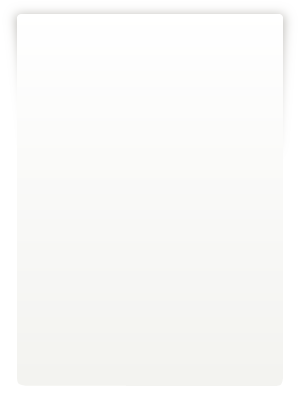
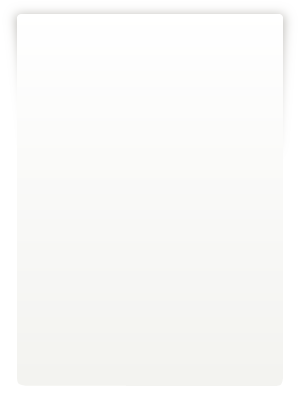
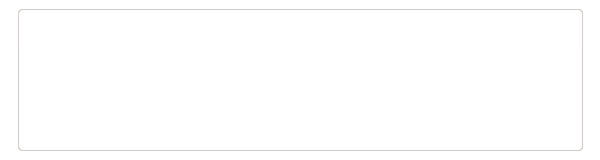
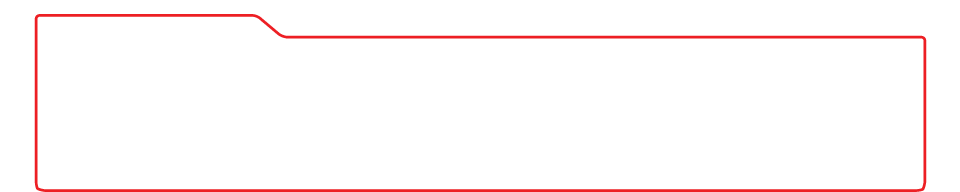
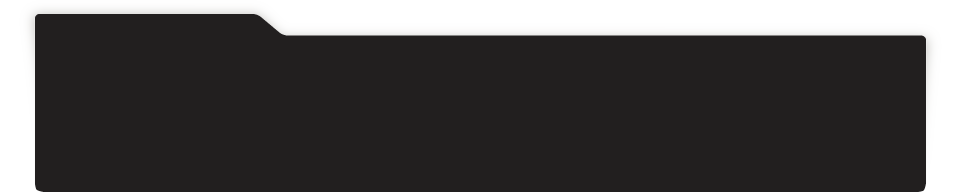
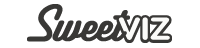
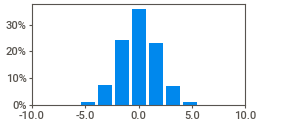
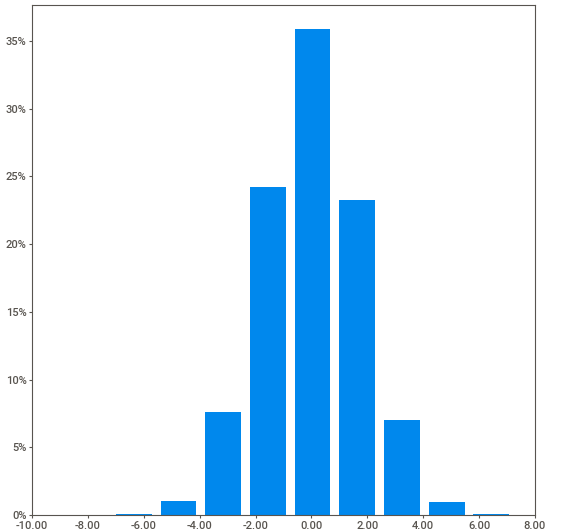
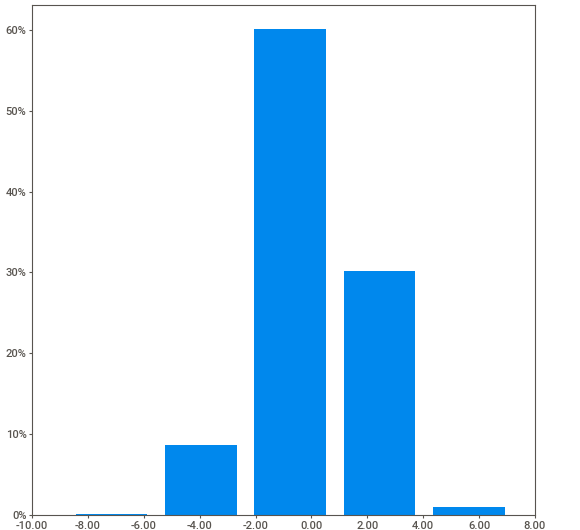
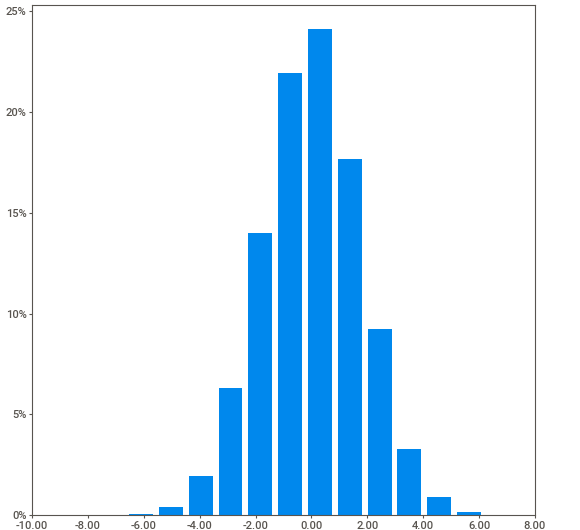
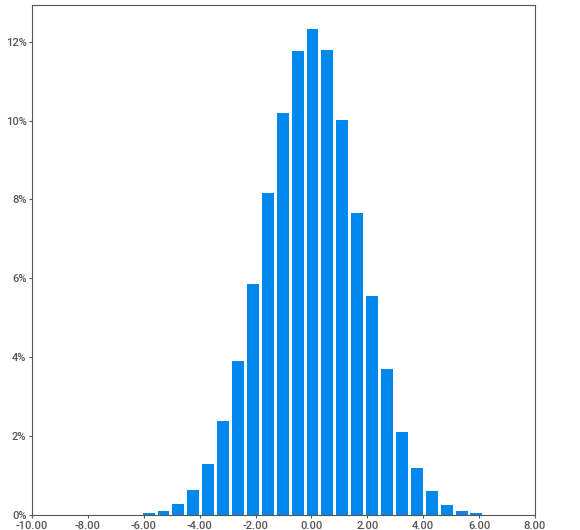
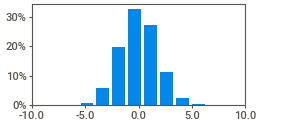
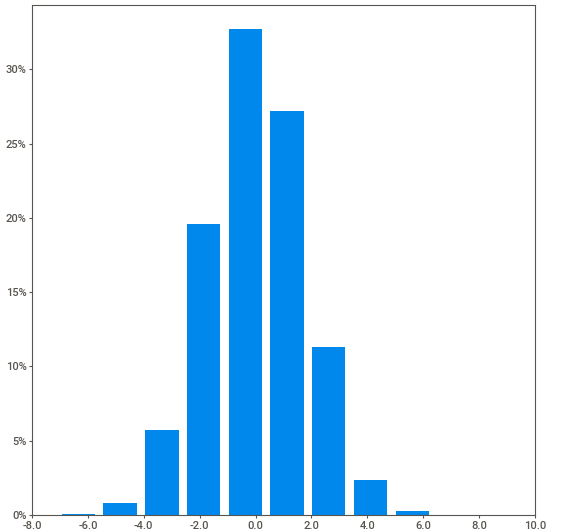
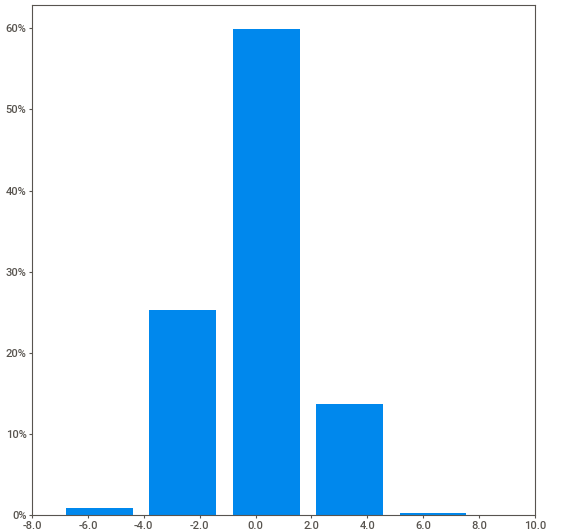
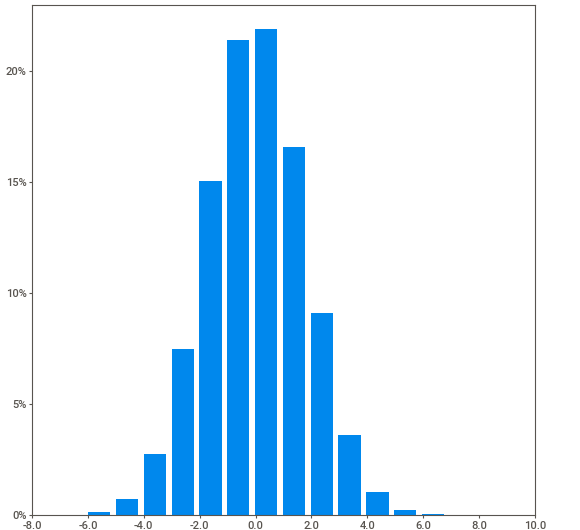
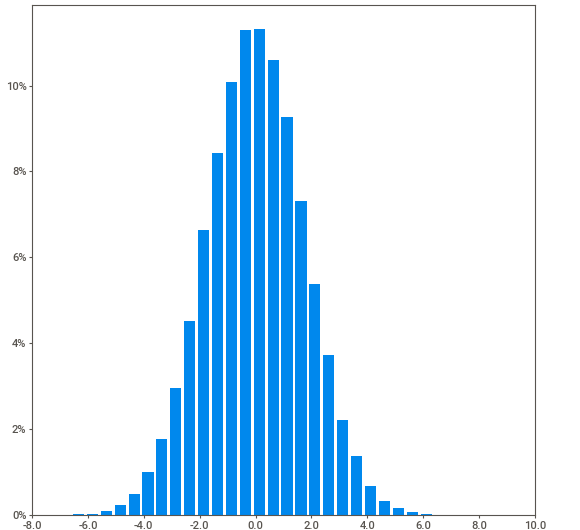
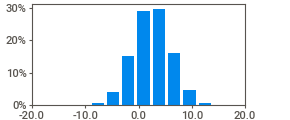
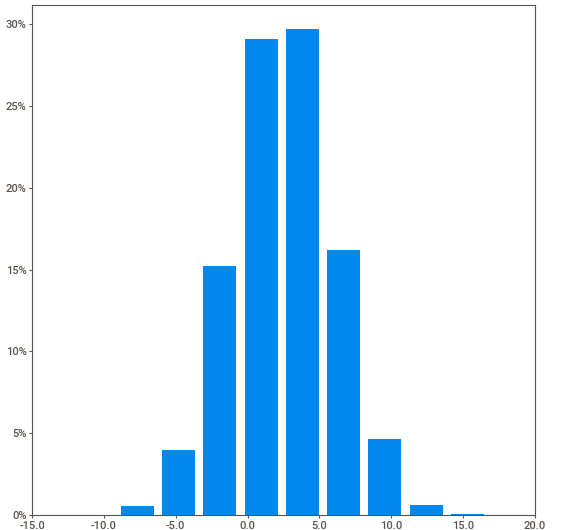
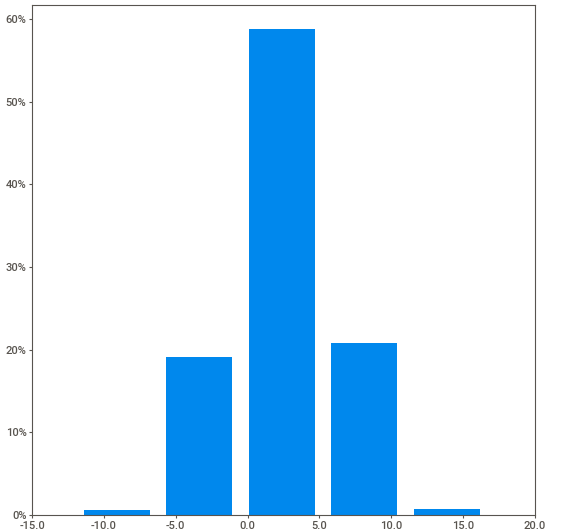
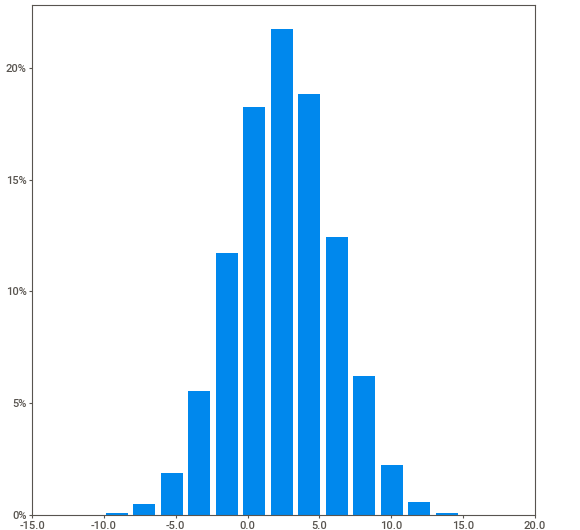
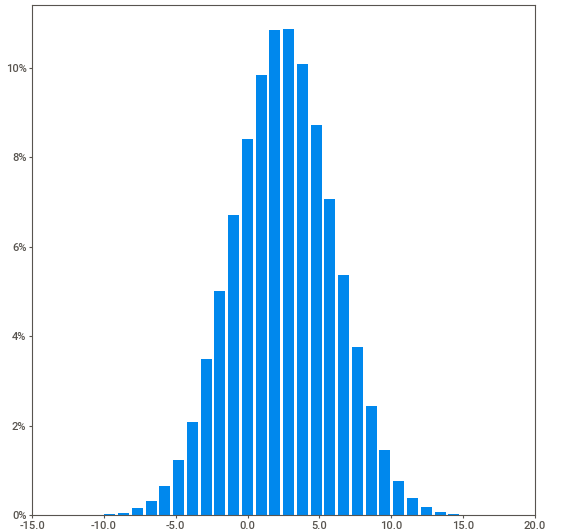
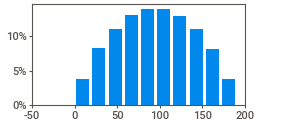
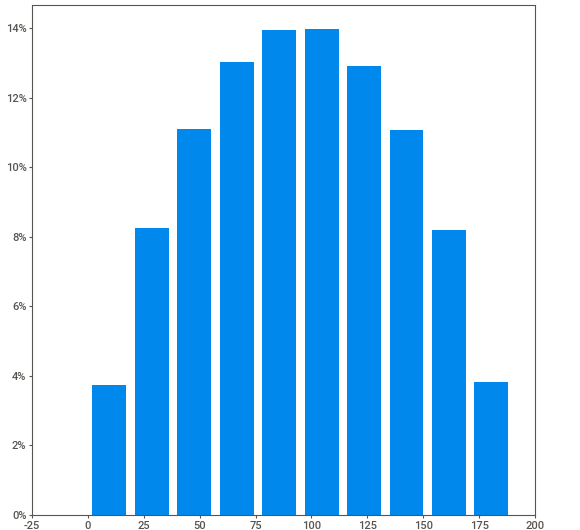
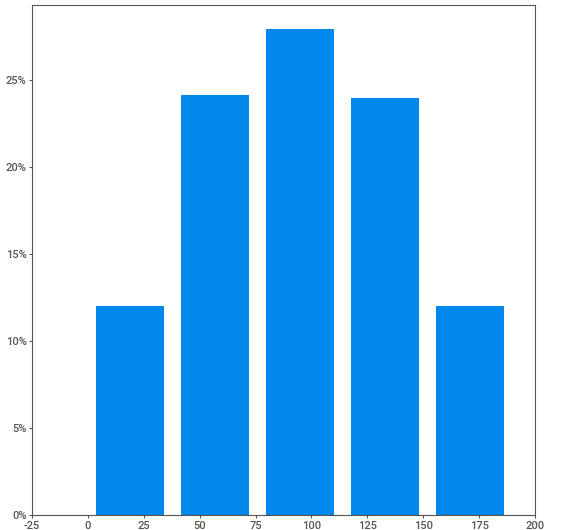
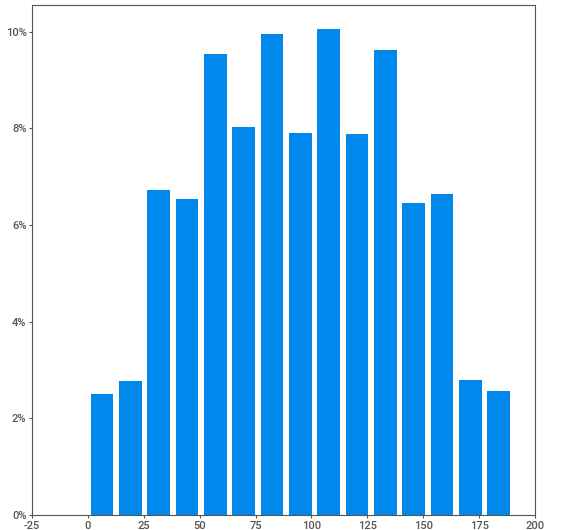
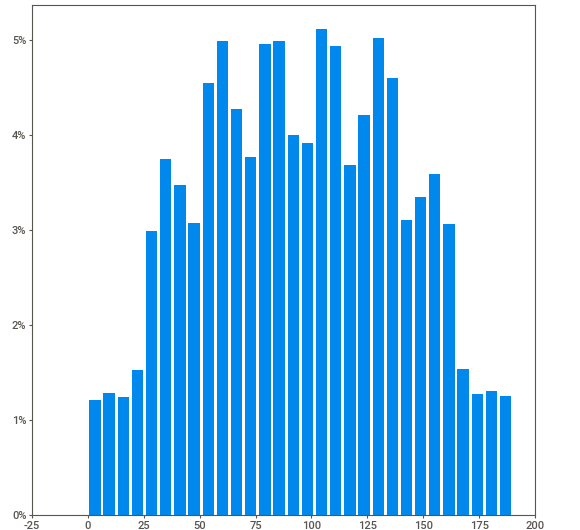
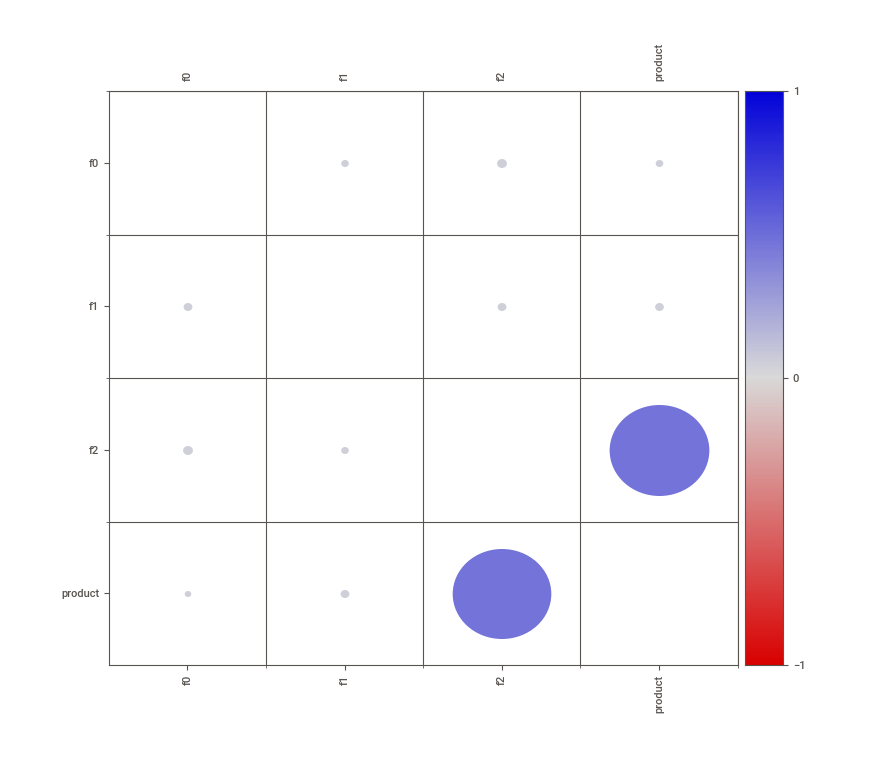
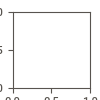

In [ ]:
# отчет о регионе № 3
report_3.show_notebook()

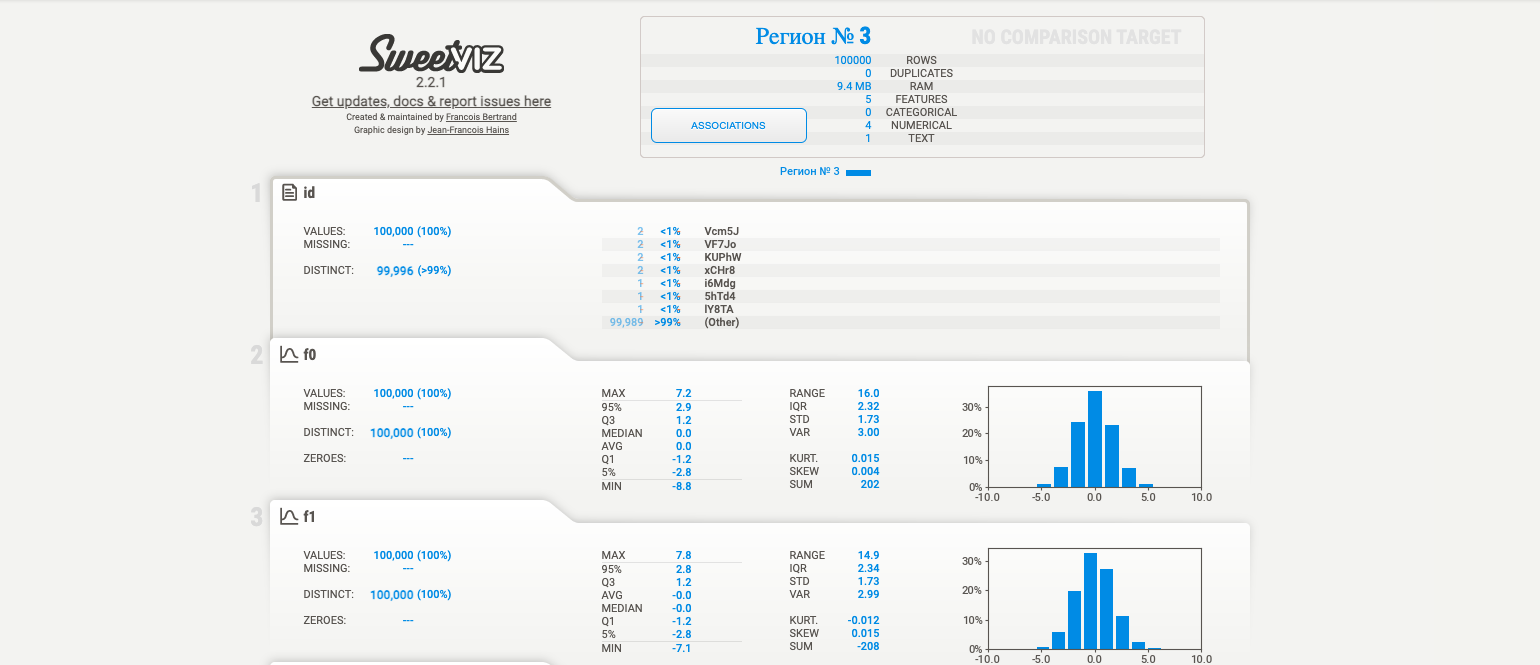

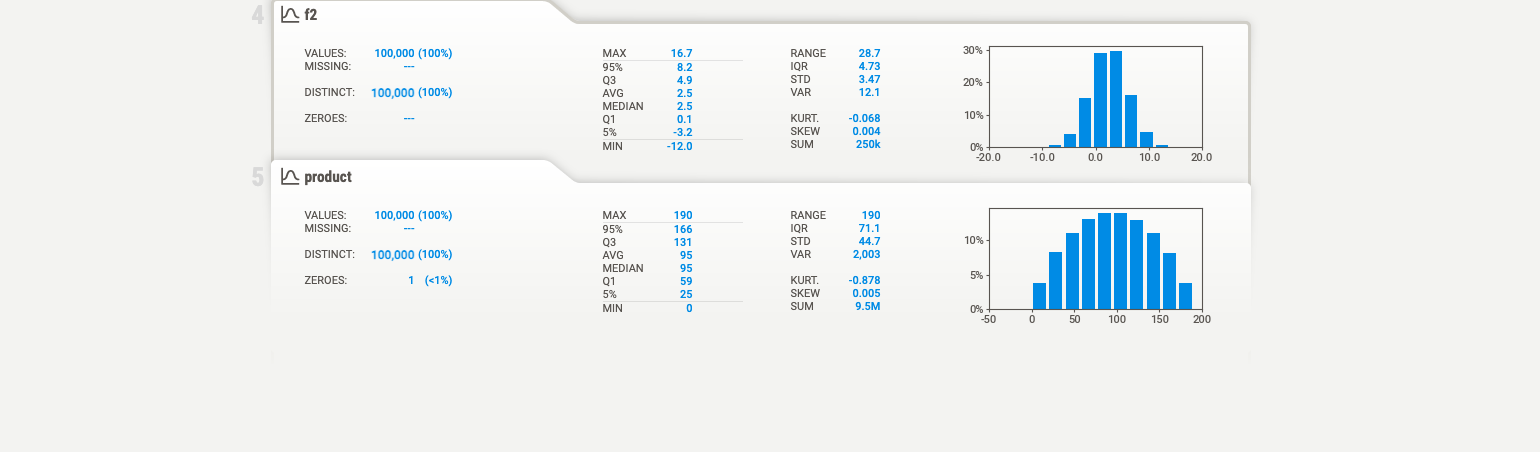

**Вывод:**

- Пропуски и явные дубликаты в датасете отсутствуют.
- Распределение всех признаков  нормальное.
- Как и в предыдущих данных наибольшая корреляция наблюдается между целевым признаком и f2.

Явные дубликаты в датасетах отсутствуют. Проверим наличие неявных дубликатов - одних и тех же вышек с разными параметрами:

In [ ]:
print('Неявные дубликаты в первом датасете:', region_1['id'].duplicated().sum())
print('Неявные дубликаты во втором датасете:', region_2['id'].duplicated().sum())
print('Неявные дубликаты в третьем датасете:', region_3['id'].duplicated().sum())

Неявные дубликаты в первом датасете: 10
Неявные дубликаты во втором датасете: 4
Неявные дубликаты в третьем датасете: 4


Создадим списки с дубликатами, чтобы в конце исследования сформировать баг-репорт.

In [ ]:
print(region_1[region_1['id'].duplicated(keep=False)]['id'].unique().tolist(),
      region_2[region_2['id'].duplicated(keep=False)]['id'].unique().tolist(),
      region_3[region_3['id'].duplicated(keep=False)]['id'].unique().tolist(),)

['HZww2', 'bxg6G', 'QcMuo', 'A5aEY', 'fiKDv', 'Tdehs', 'AGS9W', 'TtcGQ', '74z30', 'bsk9y'] ['LHZR0', 'bfPNe', '5ltQ6', 'wt4Uk'] ['VF7Jo', 'xCHr8', 'Vcm5J', 'KUPhW']


Удалим неявные дубликаты, количество потерь данных будет незначительным:

In [ ]:
region_1 = region_1.drop_duplicates(subset='id').reset_index(drop='True')
region_2 = region_2.drop_duplicates(subset='id').reset_index(drop='True')
region_3 = region_3.drop_duplicates(subset='id').reset_index(drop='True')

Проверим получившийся объем данных:

In [ ]:
print(region_1.shape[0],region_2.shape[0],region_3.shape[0])

99990 99996 99996


### Деление данных на выборки

Напишем функцию для деления датасетов на обучающую и валидационную выборки в соотношении 75/25 соответственно:

In [ ]:
def sample_split(df):
    features = df.drop(['id','product'],axis=1)
    target = df['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                  target,
                                                                                  test_size=0.25,
                                                                                  random_state=12345)
    return features_train, features_valid, target_train, target_valid

In [ ]:
features1_train, features1_valid, target1_train, target1_valid = sample_split(region_1)
features2_train, features2_valid, target2_train, target2_valid = sample_split(region_2)
features3_train, features3_valid, target3_train, target3_valid = sample_split(region_3)

Проверим получившиеся выборки:

In [ ]:
print('Размер обучающей выборки первого региона:', (len(features1_train)/len(region_1))*100)
print('Размер обучающей выборки второго региона:', (len(features2_train)/len(region_2))*100)
print('Размер обучающей выборки третьего региона:', (len(features3_train)/len(region_3))*100)

Размер обучающей выборки первого региона: 74.999499949995
Размер обучающей выборки второго региона: 75.0
Размер обучающей выборки третьего региона: 75.0


### Стандартизация данных

Cтандартизируем столбцы с разным масштабом с помощью StandardScaler:

In [ ]:
# напишем функцию для стандартизации
def scaler(features_train,features_valid):
    numeric=['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])

    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric]= scaler.transform(features_valid[numeric])

    return features_train,features_valid

In [ ]:
# стандартизируем данные
features1_train, features1_valid = scaler(features1_train, features1_valid)
features2_train, features2_valid = scaler(features2_train, features2_valid)
features3_train, features3_valid = scaler(features3_train, features3_valid)

### Вывод

На этапе предобработки и подгтовки признаков:
- Были выявлены аномалии в данных для региона №2. Коэффициент корреляция целевого признака и признака f2 равен 0.99.
- Удалили неявые дубликаты из датасетов.
- Разделили данные каждого региона на обучающую и валидационную выборки в соотношении 75/25 соответственно.
- Стандартизировали данные с помощью StandardScaler.

## Обучение и проверка модели

Напишем функцию модели линейной регрессии для прогнозирования средних запасов сырья в скважинах:

In [ ]:
def linear_regression(features_train,target_train,features_valid,target_valid):

    # обучим модель линейной регрессии
    model = LinearRegression()
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)

    # в качестве метрики возьмем корень из среднеквадратичной ошибки
    rmse = mean_squared_error(target_valid,predictions_valid, squared=False)
    # рассчитаем средний запас сырья на одну скважину
    mean_reserve = predictions_valid.mean()

    print("RMSE модели линейной регрессии на валидационной выборке:", rmse.round(2))
    print("Средний запас сырья на одну скважину, тыс. баррелей:", mean_reserve.round(2))

    return predictions_valid

In [ ]:
print('Прогнозы для первого региона:')
predictions_reg_1 = linear_regression(features1_train,target1_train, features1_valid, target1_valid)

Прогнозы для первого региона:
RMSE модели линейной регрессии на валидационной выборке: 37.85
Средний запас сырья на одну скважину, тыс. баррелей: 92.79


In [ ]:
print('Прогнозы для второго региона:')
predictions_reg_2 = linear_regression(features2_train,target2_train, features2_valid, target2_valid)

Прогнозы для второго региона:
RMSE модели линейной регрессии на валидационной выборке: 0.89
Средний запас сырья на одну скважину, тыс. баррелей: 69.18


In [ ]:
print('Прогнозы для третьего региона:')
predictions_reg_3 = linear_regression(features3_train,target3_train, features3_valid, target3_valid)

Прогнозы для третьего региона:
RMSE модели линейной регрессии на валидационной выборке: 40.08
Средний запас сырья на одну скважину, тыс. баррелей: 94.87


### Вывод

Как и ожидалось, меньше всего ошибается модель, обученная на данных второго региона (RMSE модели всего 0.89). Остальные модели ошибаются намного сильнее - в среднем на 40 тыс. баррелей.

Наибольший средний запас сырья на одну скважину по прогнозам моделей в регионах № 1 и 3, наименьший - в регионе № 2.

## Подготовка к расчёту прибыли

Объявим константы из условий задачи:

In [ ]:
BUDGET = 10**10
UNIT_REVENUE = 450000
NUM_BOREHOLES = 200

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины:

In [ ]:
MIN_NUM_BARRELS = BUDGET / (NUM_BOREHOLES*UNIT_REVENUE)
print("Минимальное необходимое количество сырья на одну скважину для безубыточной разработки, тыс. баррелей:",round(MIN_NUM_BARRELS,2))

Минимальное необходимое количество сырья на одну скважину для безубыточной разработки, тыс. баррелей: 111.11


По прогнозируемым средним запасам сырья на одну скважину ни один регион не достигает порогового значения. Следовательно выбирать точки случайным образом нельзя, необходимы модели для подбора скважин с наибольшими запасами.

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [ ]:
def revenue(predictions,target):

    # выровняем индексы
    predictions = pd.Series(predictions).reset_index(drop=True)
    target = pd.Series(target).reset_index(drop=True)

    # отсортируем предсказания модели по убыванию и возьмем первые 200 скважин
    predictions_sorted = predictions.sort_values(ascending=False).head(200)

    # для расчета прибыли возьмем фактические данные отобранных моделью скважин
    selected = target[predictions_sorted.index]

    # посчитаем прибыль
    revenue = ((selected.sum()*UNIT_REVENUE)-BUDGET)/10**9

    return revenue

Посчитаем фактическую прибыль в каждом регионе с выбранных моделью скважин:

In [ ]:
revenue_1 = revenue(predictions_reg_1, target1_valid)
print(f'Прибыль с выбранных моделью скважин в регионе № 1 составляет: {revenue_1.round(3)} млрд. руб.')

Прибыль с выбранных моделью скважин в регионе № 1 составляет: 3.365 млрд. руб.


In [ ]:
revenue_2 = revenue(predictions_reg_2, target2_valid)
print(f'Прибыль с выбранных моделью скважин в регионе № 2 составляет: {revenue_2.round(3)} млрд. руб.')

Прибыль с выбранных моделью скважин в регионе № 2 составляет: 2.415 млрд. руб.


In [ ]:
revenue_3 = revenue(predictions_reg_3, target3_valid)
print(f'Прибыль с выбранных моделью скважин в регионе № 3 составляет: {revenue_3.round(3)} млрд. руб.')

Прибыль с выбранных моделью скважин в регионе № 3 составляет: 2.501 млрд. руб.


Наибольшая фактическая прибыль с выбранных моделью скважин получилась в регионе №1 и составила ~ 3.3 млрд. руб. Наименьшая прибыль в регионе № 2 ~ 2.4 млрд. руб.

## Расчёт прибыли и рисков

Применим технику **Bootstrap** с 1000 выборок, чтобы найти распределение прибыли. Напишем функцию для расчета средней прибыли, 95%-го доверительного интервала и риска убытков:

In [ ]:
def revenue_bootstrap (predictions,target, num_reg):

    state = np.random.RandomState(12345)
    values = []

    for i in range(1000):

        # создадим подвыборку из 500 рандомных скважин
        target_subsample = target.reset_index(drop=True).sample(n=500, replace=True, random_state=state)
        pred_subsample = predictions[target_subsample.index]

        # отбираем топ-200 скважин по предсказанным данным, рассчитываем прибыль по фактическим данным
        rev = revenue(pred_subsample,target_subsample)
        values.append(rev)

    values = pd.Series(values)
    # среднее значение прибыли
    mean_revenue = values.mean()
    # 2.5%-квантиль
    lower = values.quantile(0.025)
    # 97.5%-квантиль
    upper = values.quantile(0.975)
    # доверительный интервал
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    confidence_interval = (round(confidence_interval[0], 3), round(confidence_interval[1], 3))
    # риск убытков
    probability_of_loss = ((values < 0).mean())*100

    plt.figure(figsize=(15, 6))
    plt.hist(values, bins=30, edgecolor='k', alpha=0.7)

    # наносим вертикальные линии для среднего значения и доверительного интервала
    plt.axvline(x=mean_revenue, color='r', linestyle='dashed', linewidth=2, label='Среднее значение')
    plt.axvline(x=lower, color='g', linestyle='dashed', linewidth=2, label='Доверительный интервал')
    plt.axvline(x=upper, color='g', linestyle='dashed', linewidth=2)

    # добавляем легенду
    plt.legend(loc='best')

    # настройка подписей
    plt.xlabel('Прибыль, млрд. руб.')
    plt.ylabel('Частота')
    plt.title(f'Регион №{num_reg}: распределение прибыли')

    plt.show()

    return [mean_revenue, lower, upper, confidence_interval, probability_of_loss]


Создадим итоговую таблицу с расчетами для каждого региона:

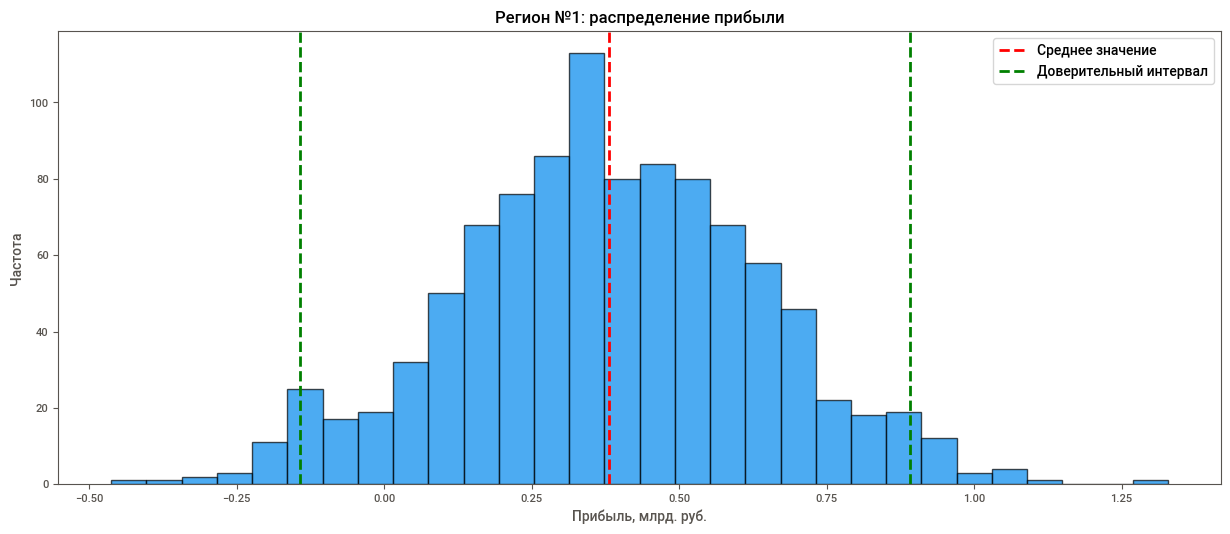

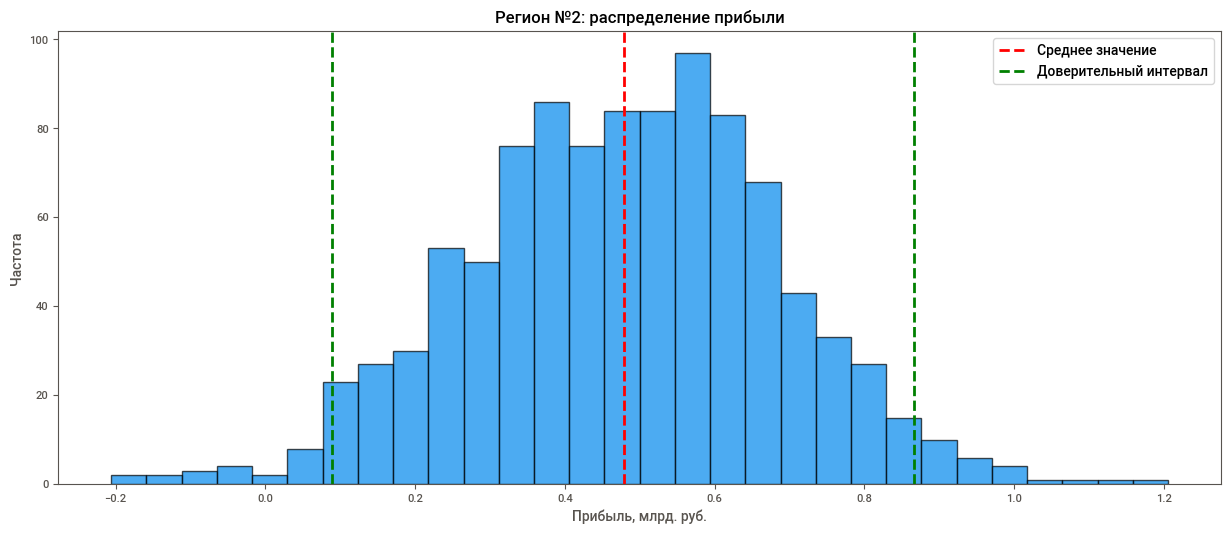

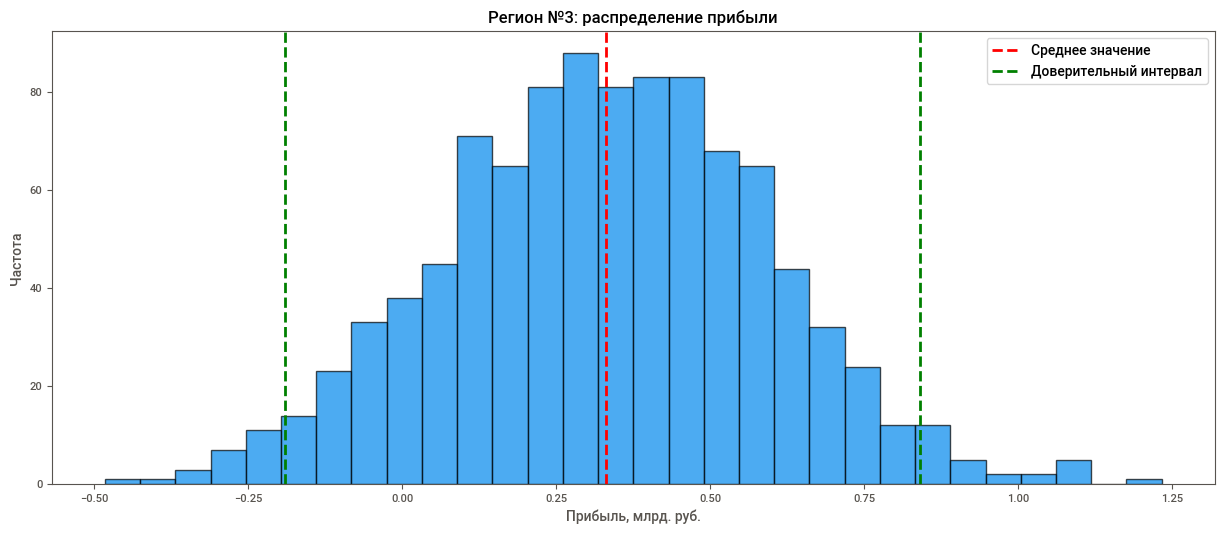

,"Средняя прибыль, млрд. руб.","2.5% квантиль, млрд. руб.","97.5% квантиль, млрд. руб.",95% доверительный интервал,"Риск убытков, %"
Регион 1,0.381,-0.143,0.891,"(0.365, 0.397)",7.7%
Регион 2,0.478,0.090,0.867,"(0.466, 0.491)",1.2%
Регион 3,0.331,-0.190,0.840,"(0.314, 0.347)",11.3%


In [ ]:
# собираем результаты функции в список
results_list = [
    revenue_bootstrap(predictions_reg_1, target1_valid, 1),
    revenue_bootstrap(predictions_reg_2, target2_valid, 2),
    revenue_bootstrap(predictions_reg_3, target3_valid, 3)
]

# создаем датафрейм из списка результатов
df = pd.DataFrame(results_list, index=['Регион 1', 'Регион 2', 'Регион 3'], columns=[
    'Средняя прибыль, млрд. руб.',
    '2.5% квантиль, млрд. руб.',
    '97.5% квантиль, млрд. руб.',
    '95% доверительный интервал',
    'Риск убытков, %'
])

# "подсветим" регионы, где риск убытков меньше 2.5%
def highlight_low_risk(row):
    if row['Риск убытков, %'] < 2.5:
        return ['background-color: green;color: white'] * len(row)
    else:
        return [''] * len(row)

df = df.style.apply(highlight_low_risk, axis=1)

# приведем формат чисел в удобный для анализа вид
df.format({
    'Средняя прибыль, млрд. руб.': '{:.3f}',
    '2.5% квантиль, млрд. руб.': '{:.3f}',
    '97.5% квантиль, млрд. руб.': '{:.3f}',
    'Риск убытков, %': '{:.1f}%',
})
# выведем итоговую таблицу
display(df)

## Итоговый вывод

Выбор региона, где добыча принесёт наибольшую прибыль, будем основывать на данных, полученных с помощью техники Bootstrap.
В таком случае для разработки лучше всего подходит **регион № 2**. Риск убытков в этом регионе составляет меньше 2.5%, а средняя прибыль наибольшая - 0.478 млрд. руб.

**Баг-репорт**

В предоставленных данных имеются неявные дубликаты - одни и те же вышки с разными параметрами. Возможно, дублировование происходит при формировании или выгрузке данных. ID дублирующихся вышек прилагаю.

Дубликаты в geo_data_0.csv (10):
'HZww2', 'bxg6G', 'QcMuo', 'A5aEY', 'fiKDv', 'Tdehs', 'AGS9W', 'TtcGQ', '74z30', 'bsk9y'

Дубликаты в geo_data_1.csv (4):
'LHZR0', 'bfPNe', '5ltQ6', 'wt4Uk'

Дубликаты в geo_data_2.csv (4):
'VF7Jo', 'xCHr8', 'Vcm5J', 'KUPhW'